# 1. Fixed income and yield curve construction

In this project we will implement

- building yield curve from par yields for US and japan data with 4 different methods and comparison
- creating a rolling synthetic portfolio of bonds
- analysis and pricing of the bonds in portfolio
- risk and sensitivity measures of bonds 


## 1) Bonds, Coupons, Treasuries, and Par Yields

### 1.1 Fixed-coupon bond cashflows
A standard coupon bond is defined by:
- notional $N$ (principal. the money that you get back)
- annual coupon rate $c$ (the interest rate of the bond)
- maturity $T$ (the time that bond ends and you get back principal and interest)
- coupon frequency $f$ (the amount of payments per year)

Coupon payment each period is $\dfrac{c}{f}N$.

Payment times are
$t_i=\dfrac{i}{f}$ for $i=1,2,\dots,n$ &nbsp;&nbsp;&nbsp;&nbsp; where $n=fT$

Cashflows for each period $i$ is
$CF_i=\dfrac{c}{f}N$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $i=1,\dots,n-1$ 

final cash flow: $CF_n=\dfrac{c}{f}N+N$

---

### 1.2 Price from discount factors
For calculating price of a bond we need to discount all the cash flows to today value to compute the present value of the bond. for that we need to have a discount rate for every $t$ that a cash flow accurs. this comes from a continous function of time which is discount curve $D(t)$, the price is
$P=\sum_{i=1}^{n} CF_i\,D(t_i)$

---

### 1.3 Year fraction from dates
Given dates $d_0$ and $d_1$, a day-count year fraction is
$\tau(d_0,d_1)=\dfrac{\text{days}(d_0,d_1)}{365}$

---

### 1.4 Tenor mapping
Tenor labels map to maturities:
- $k$ M → $T=k/12$
- $k$ Y → $T=k$

Collect maturities into a numeric vector:
$\mathbf{T}=(T_1,T_2,\dots,T_m)$  
Observed market par yields:
$\mathbf{y}=(y_1,y_2,\dots,y_m)$ with $y_j=y(T_j)$

---

### 1.5 What “Treasury par yield” means
A par yield at maturity $T$ is the coupon rate $c(T)$ that makes a standard coupon bond price equal to par:
$P(T,c(T))=N$
If we normalize $N=1$, then par means $P=1$.

For discounting, we use these yields but the problem is we have some of the standard maturities which may not be the same as other bonds. so that's why we have to make this yield curve from the treasury maturities to be able to discount any time to present.

you can download the data used in this notebook here [(treasury par yields from 1990 to 2026)][]

[(treasury par yields from 1990 to 2026)]: https://home.treasury.gov/resource-center/data-chart-center/interest-rates/daily-treasury-rate-archives

---

## Imports and plotting style and loading data


In [2]:
import math
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cycler import cycler

warnings.filterwarnings("ignore")


colors = ["#069AF3","#FE420F", "#00008B", "#008080", "#7BC8F6","#800080","#0072B2","#008000","#CC79A7", "#DC143C", "#04D8B2"]
plt.rcParams["axes.prop_cycle"] = cycler(color=colors)
plt.rcParams.update({
    "figure.figsize": (6, 3),
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "axes.grid": True,
    "grid.alpha": 0.20,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 6,
})


df = pd.read_csv(r"E:\daneshgah\quantitative-finance-lab\data\par-yield-curve-rates-1990-2026.csv")

col_map = {"date": "Date","1 mo": "1M","2 mo": "2M","3 mo": "3M","4 mo": "4M","6 mo": "6M","1 yr": "1Y","2 yr": "2Y","3 yr": "3Y","5 yr": "5Y","7 yr": "7Y","10 yr": "10Y","20 yr": "20Y","30 yr": "30Y"}

df = df.rename(columns={k.lower(): v for k, v in col_map.items()})
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"], ).set_index("Date").sort_index()

df

1M    2M    3M    4M    6M    1Y    2Y    3Y    5Y    7Y   10Y  \
Date                                                                           
1990-01-02   NaN   NaN  7.83   NaN  7.89  7.81  7.87  7.90  7.87  7.98  7.94   
1990-01-03   NaN   NaN  7.89   NaN  7.94  7.85  7.94  7.96  7.92  8.04  7.99   
1990-01-04   NaN   NaN  7.84   NaN  7.90  7.82  7.92  7.93  7.91  8.02  7.98   
1990-01-05   NaN   NaN  7.79   NaN  7.85  7.79  7.90  7.94  7.92  8.03  7.99   
1990-01-08   NaN   NaN  7.79   NaN  7.88  7.81  7.90  7.95  7.92  8.05  8.02   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2026-01-22  3.79  3.72  3.71  3.67  3.61  3.53  3.61  3.68  3.85  4.05  4.26   
2026-01-23  3.78  3.72  3.70  3.67  3.61  3.53  3.60  3.67  3.84  4.03  4.24   
2026-01-26  3.77  3.70  3.67  3.67  3.62  3.52  3.56  3.66  3.82  4.02  4.22   
2026-01-27  3.77  3.70  3.67  3.66  3.61  3.50  3.53  3.65  3.81  4.03  4.24   
2026-01-28  3.76  3.71  3.68  3.70  3.63  3.52  3.56  3.66  3.83  4.05  4.26   

             20Y   30Y  
Date                    
1990-01-02   NaN  8.00  
1990-01-03   NaN  8.04  
1990-01-04   NaN  8.04  
1990-01-05   NaN  8.06  
1990-01-08   NaN  8.09  
...          ...   ...  
2026-01-22  4.79  4.84  
2026-01-23  4.78  4.82  
2026-01-26  4.75  4.80  
2026-01-27  4.79  4.83  
2026-01-28  4.81  4.85  

[9024 rows x 13 columns]


Data shape: (9024, 13)
Date range: 1990-01-02 to 2026-01-28


count      mean       std   min   25%   50%    75%   max
1M   6124.0  1.669061  1.834318  0.00  0.08  0.98  2.700  6.02
2M   1819.0  2.731045  2.092637  0.00  0.14  2.43  4.635  5.61
3M   9020.0  2.793844  2.279473  0.00  0.23  2.74  5.010  8.26
4M    817.0  4.826524  0.600693  3.58  4.35  4.77  5.440  5.64
6M   9023.0  2.908257  2.296244  0.02  0.41  3.00  5.100  8.49
1Y   9023.0  3.004545  2.274365  0.04  0.56  3.12  5.025  8.64
2Y   9023.0  3.243374  2.267325  0.09  0.94  3.35  4.990  9.05
3Y   9023.0  3.422187  2.212582  0.10  1.37  3.55  5.050  9.11
5Y   9023.0  3.761102  2.107014  0.19  1.81  3.73  5.380  9.10
7Y   9023.0  4.037397  2.028457  0.36  2.22  3.93  5.600  9.12
10Y  9023.0  4.251091  1.937830  0.52  2.61  4.17  5.710  9.09
20Y  8084.0  4.377290  1.629305  0.87  2.89  4.53  5.540  8.30
30Y  8029.0  4.735390  1.879145  0.99  3.08  4.56  6.130  9.18

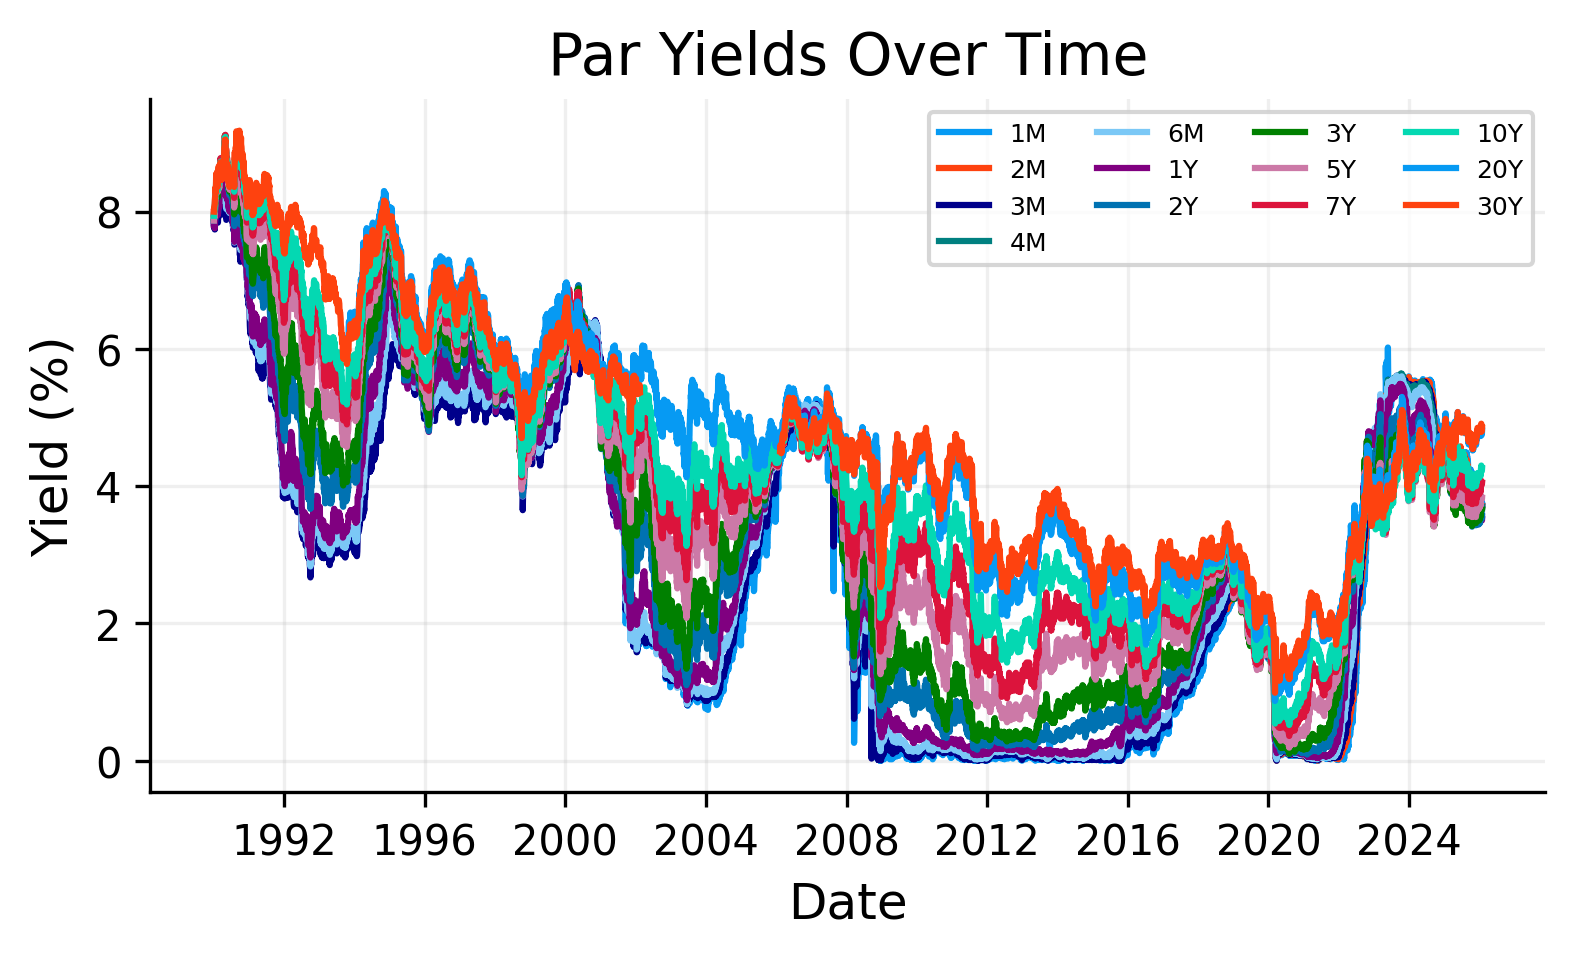

First available date per tenor:


tenor first_valid_date
2     3M       1990-01-02
4     6M       1990-01-02
5     1Y       1990-01-02
6     2Y       1990-01-02
7     3Y       1990-01-02
8     5Y       1990-01-02
9     7Y       1990-01-02
10   10Y       1990-01-02
12   30Y       1990-01-02
11   20Y       1993-10-01
0     1M       2001-07-31
1     2M       2018-10-16
3     4M       2022-10-19

In [3]:
tenor_cols = ["1M","2M","3M","4M","6M","1Y","2Y","3Y","5Y","7Y","10Y","20Y","30Y"]
for c in tenor_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

first_valid = df[tenor_cols].apply(lambda s: s.first_valid_index())
availability = pd.DataFrame({
    "tenor": tenor_cols,
    "first_valid_date": [first_valid[t] for t in tenor_cols],
})
availability["first_valid_date"] = pd.to_datetime(availability["first_valid_date"])
availability = availability.sort_values("first_valid_date")



print("\nData shape:", df.shape)
print("Date range:", df.index.min().date(), "to", df.index.max().date())
display(df[tenor_cols].describe().T)


plt.figure()
for c in df.columns:
    plt.plot(df.index, df[c], label=c)
plt.title("Par Yields Over Time")
plt.ylabel("Yield (%)")
plt.xlabel("Date")
plt.legend(ncol= 4)
plt.show()


print("First available date per tenor:")
display(availability)


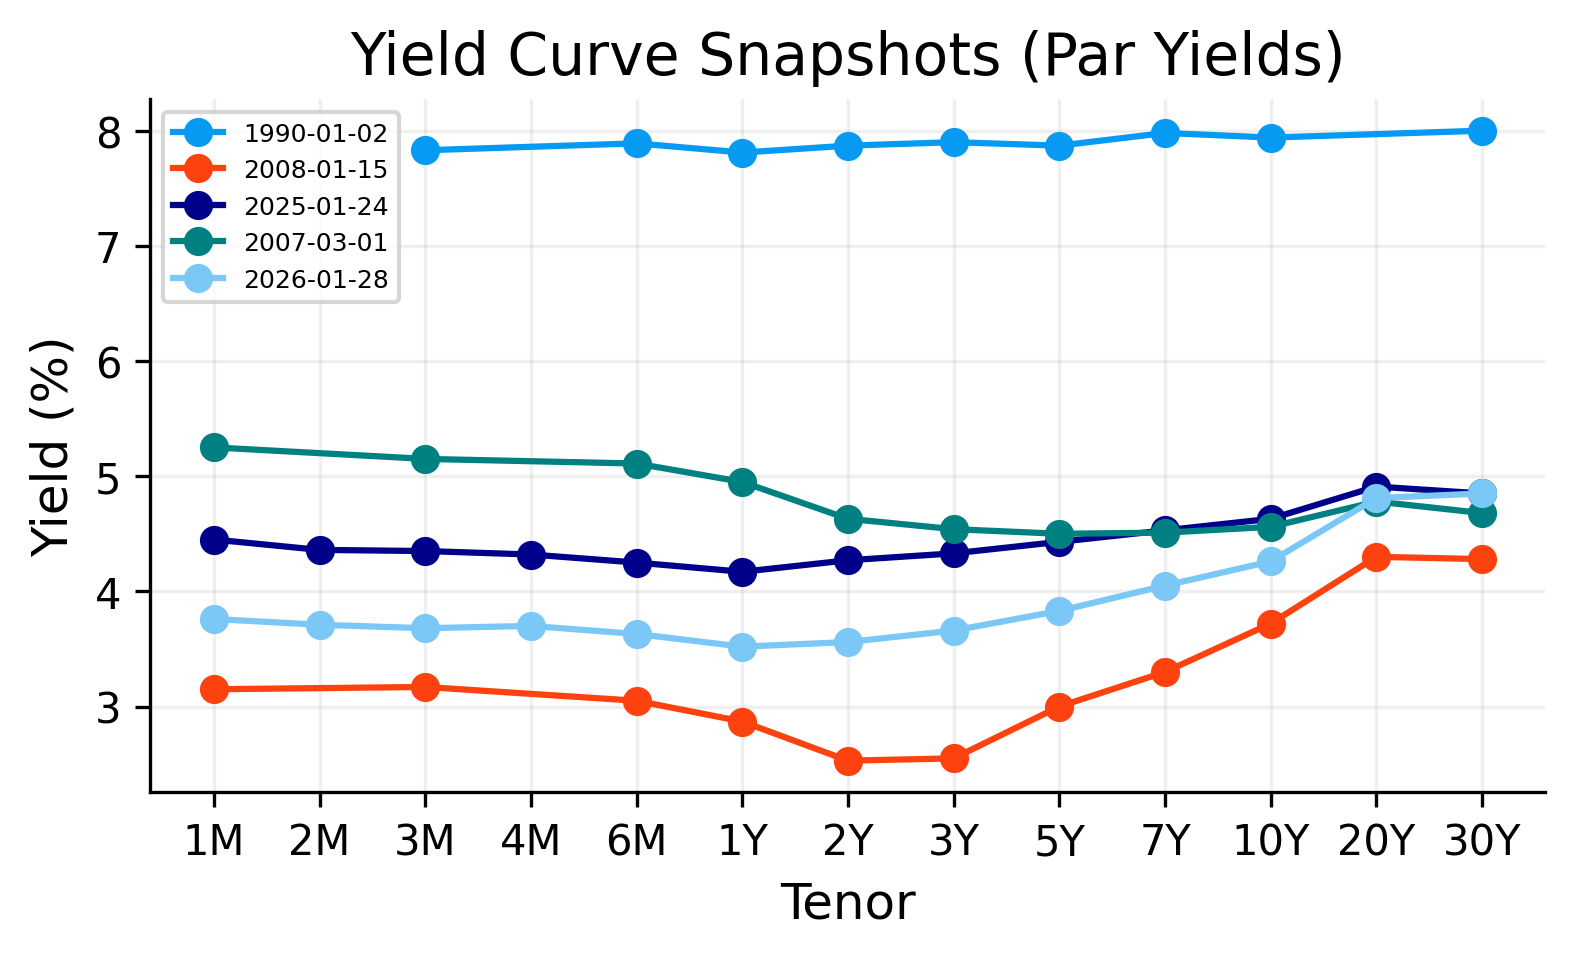

In [4]:
sample_dates = [
    df.index[0],
    df.index[len(df)//2],
    df.index[-252],
    df.index[df.index <= pd.Timestamp("2007-03-01")][-1],
    df.index[-1]
]

x = np.arange(len(tenor_cols))  

plt.figure()
for d in sample_dates:
    y = df.loc[d, tenor_cols].astype(float)
    mask = np.isfinite(y.values)
    plt.plot(x[mask], y.values[mask], marker="o", label=d.strftime("%Y-%m-%d"))

plt.title("Yield Curve Snapshots (Par Yields)")
plt.xticks(x, tenor_cols)
plt.ylabel("Yield (%)")
plt.xlabel("Tenor")
plt.legend()
plt.show()



## 3) Discount Factors, Zero Rates, and Forward Rates

### 3.1 Discount factor
$D(t)$ is the present value of receiving 1 unit of currency at time $t$. For example what does 1 dollar in 20 years worth now.

### 3.2 Zero rate (continuous compounding)

$z(t)$ is the constant rate that discounts a payment in $t$ to present. for example, if we want to know discount factor of 1 dollar in 20 years we need an annual rate to compute the present value. that's zero rate.

Define $z(t)$ by
$$
D(t)=e^{-z(t)t}
$$
$$
z(t)=-\dfrac{\ln D(t)}{t}
$$

### 3.3 Instantaneous forward rate
$f(t)$ is the slope of $z(t)$ which tells us how much the rate of return is very close to the time of maturity. it is used because zero rate is smooth and in instant time we need to have exact forward rate

$$
f(t)=-\dfrac{d}{dt}\ln D(t)
$$
$$
D(t)=\exp\left(-\int_0^t f(u)\,du\right)
$$

### 3.4 Discrete forward over an interval
For $t_1<t_2$, the continuously-compounded forward rate for the interval is
$$
F(t_1,t_2)=\dfrac{\ln D(t_1)-\ln D(t_2)}{t_2-t_1}
$$


---

## 4) Par Yield Implied by a Curve

This is used for building yield curve and validation to see if the predicted rate is close to real rate based on curve. what is the rate that makes the price of bond (PV of cashflows) equal to 1?

Given a curve $D(t)$, the par coupon rate for maturity $T$ and frequency $f$ solves

$1=\sum_{i=1}^{n}\dfrac{c}{f}D(t_i)+D(T)$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $t_i=i/f$, $n=fT$.


$1=\dfrac{c}{f}\sum_{i=1}^{n}D(t_i)+D(T)$


and finally we get to $c=f\,\dfrac{1-D(T)}{\sum_{i=1}^{n}D(t_i)}$



Short maturities (<1Y) often use money-market conventions because they are mostly single payment. Two common ones:
- continuous: $y=-\dfrac{\ln D(T)}{T}$
- simple: $y=\dfrac{1/D(T)-1}{T}$

---

## 5) Bootstrapping Discount Factors from Par Yields

Bootstrapping constructs $D(T)$ at market tenors from observed par yields. in this way we can have a function of time to discount a payment in any maturity based on the real yields that we have.

### 5.1 Short end (<1Y) convention
For $T<1$ we use the money market convention again. for calculating discount factor:

- continuous convention: $D(T)=e^{-y(T)T}$
- simple convention: $D(T)=\dfrac{1}{1+y(T)T}$

### 5.2 Bootstrapping for coupon tenors (T ≥ 1)
Let $c=y(T)$ be the market par yield at maturity $T$ (used as coupon rate).
With frequency $f$ and cashflow times $t_i=i/f$:

Par condition (normalized notional 1):
$$
1=\sum_{i=1}^{n-1}\dfrac{c}{f}D(t_i)+\left(1+\dfrac{c}{f}\right)D(T)
$$

Solve for the new unknown $D(T)$:
$$D(T)=\dfrac{1-\sum_{i=1}^{n-1}\dfrac{c}{f}D(t_i)}{1+\dfrac{c}{f}}
$$

if we have the earlier coupons discount factor, we know everything on the right side of equation. so we can solve it and get to $D(T)$

it's called bootstrapping because we first compute the $D(T<1Y)$ with short end convention, then we use that to compute $D(1Y)$ and then use them for $D(2Y)$ until the last maturity (30Y)

### 5.3 Interpolating discount factors at coupon dates
Bootstrapping needs $D(t_i)$ at coupon dates, but you often only have DFs at pillar maturities.

A robust choice is log-linear interpolation:
If $T_a<t<T_b$, then

$$\ln D(t)=\ln D(T_a)+\dfrac{t-T_a}{T_b-T_a}\left(\ln D(T_b)-\ln D(T_a)\right)
$$

So
$$D(t)=\exp\left(\ln D(t)\right)
$$





Base date: 2026-01-28
Tenors used: ['1M', '2M', '3M', '4M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']
First 5 pillar DFs: [0.99687157 0.99383574 0.99084219 0.98774241 0.98201372 0.96571989
 0.93185753 0.89680276 0.82670445 0.75353422 0.65216175 0.37090153
 0.22566195]


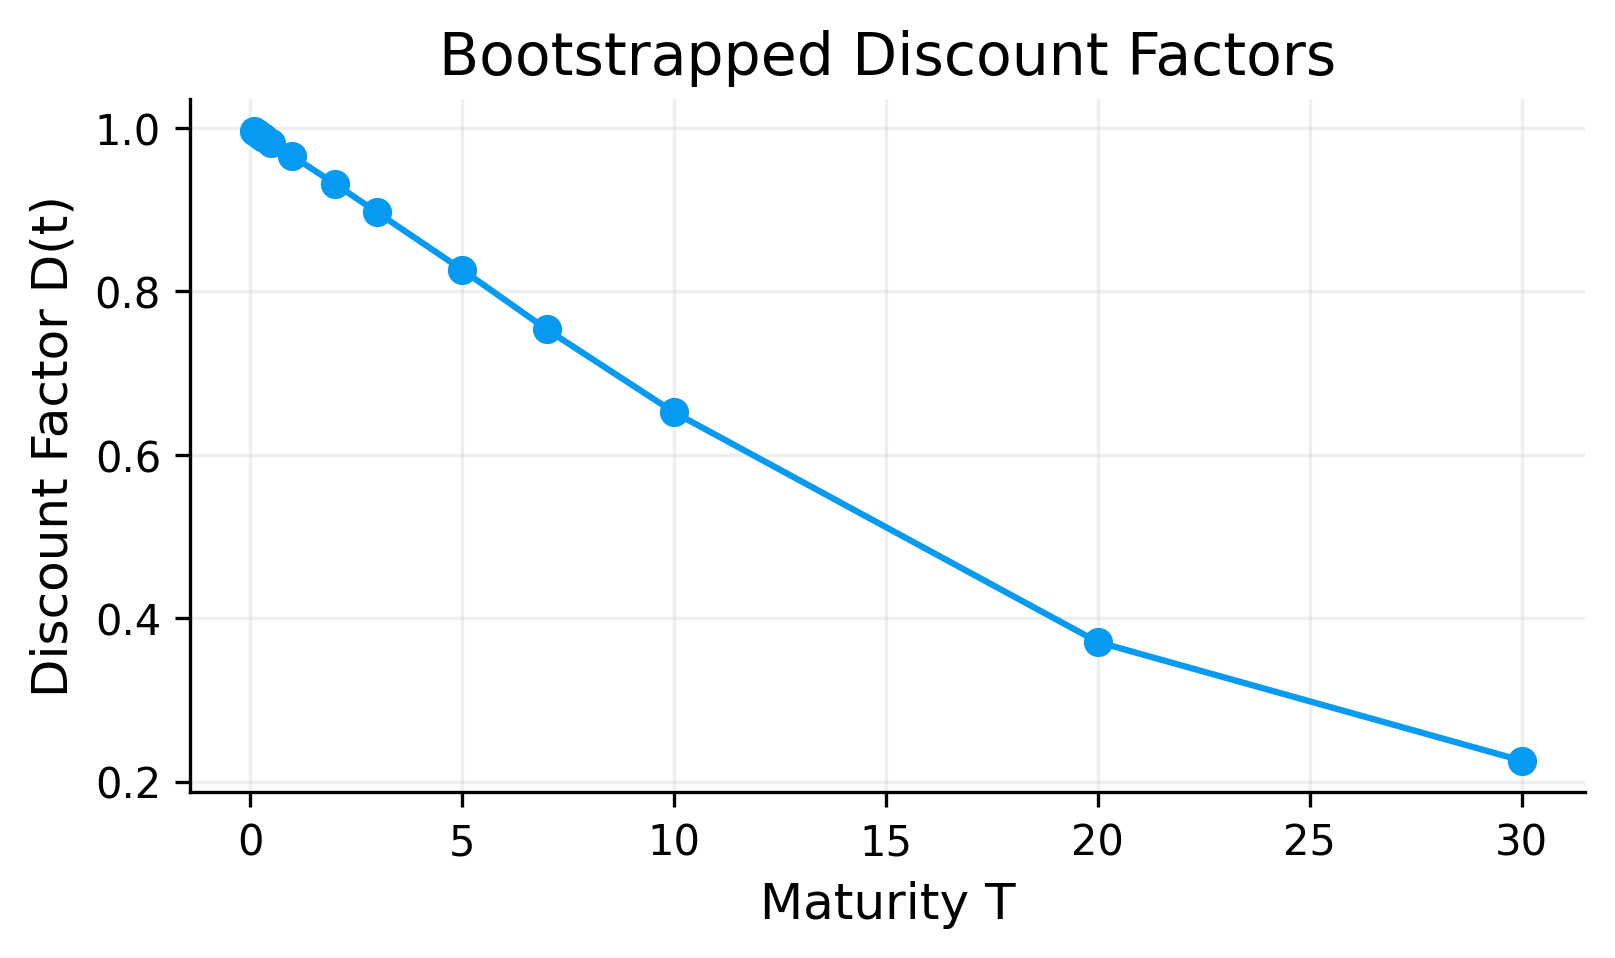

In [5]:
df_dec = df.copy()
df_dec[tenor_cols] = df_dec[tenor_cols] / 100.0

short_end_convention = "continuous"
f = 2
min_d = 1e-12


def labels_to_T(labels):
    T = []
    for lab in labels:
        labu = lab.upper().strip()
        if labu.endswith("M"):
            T.append(int(labu[:-1]) / 12.0)
        else:
            T.append(float(int(labu[:-1])))
    return np.array(T, dtype=float)


def get_par_from_row(row):
    y = row[tenor_cols].astype(float)
    mask = np.isfinite(y.values)
    labels = [tenor_cols[i] for i in range(len(tenor_cols)) if mask[i]]
    if len(labels) == 0:
        return None

    par = y.values[mask].astype(float)
    T = labels_to_T(labels)

    i = np.argsort(T)
    T = T[i]
    par = par[i]
    labels = [labels[i] for i in i]

    return T, par, labels


def get_par_for_date(date):
    row = df_dec.loc[date]
    return get_par_from_row(row)


def short_end_df(Ti, ri):
    if short_end_convention == "continuous":
        return math.exp(-ri * Ti)
    return 1.0 / (1.0 + ri * Ti)


def price_error_loglinear(d_T, Ti, t_prev, d_prev, times_interp, c, pv_known):
    d_T = max(float(d_T), min_d)
    pv_interp = 0.0
    if len(times_interp) > 0:
        w = (times_interp - t_prev) / (Ti - t_prev)
        log_d = (1 - w) * np.log(d_prev) + w * np.log(d_T)
        d_interp = np.exp(log_d)
        pv_interp = np.sum((c / f) * d_interp)
    return pv_known + pv_interp + d_T - 1.0


def solve_df_long_end(Ti, ri, d_map):
    c = float(ri)
    n = int(round(Ti * f))
    times = np.array([k / f for k in range(1, n + 1)], dtype=float)


    known_T = np.array(sorted(d_map.keys()), dtype=float)
    known_D = np.array([d_map[t] for t in known_T], dtype=float)
    known_D = np.clip(known_D, min_d, None)


    t_prev = known_T[-1]
    d_prev = known_D[-1]

    times_known = times[times <= t_prev + 1e-12]
    times_interp = times[times > t_prev + 1e-12]

    pv_known = 0.0
    if len(times_known) > 0:
        log_known_D = np.log(known_D)
        log_df_known = np.interp(times_known, known_T, log_known_D)
        d_known = np.exp(log_df_known)
        pv_known = np.sum((c / f) * d_known)

    lo = min_d
    hi = d_prev
    f_lo = price_error_loglinear(lo, Ti, t_prev, d_prev, times_interp, c, pv_known)
    f_hi = price_error_loglinear(hi, Ti, t_prev, d_prev, times_interp, c, pv_known)

    if f_lo * f_hi > 0:
    
        log_known_D = np.log(known_D)
        log_df_cpn = np.interp(
            times[:-1],
            known_T,
            log_known_D,
            left=log_known_D[0],
            right=log_known_D[-1],
        )
        d_cpn = np.exp(log_df_cpn)
        pv_coupons = np.sum((c / f) * d_cpn)
        d_T = (1.0 - pv_coupons) / (1.0 + c / f)
    else:
        for _ in range(100):
            mid = 0.5 * (lo + hi)
            f_mid = price_error_loglinear(mid, Ti, t_prev, d_prev, times_interp, c, pv_known)
            if f_lo * f_mid <= 0:
                hi = mid
                f_hi = f_mid
            else:
                lo = mid
                f_lo = f_mid
            if abs(hi - lo) < 1e-12:
                break
        d_T = 0.5 * (lo + hi)

    return d_T


def bootstrap_from_inputs(T, par, labels, date=None):
    d_map = {}

    # short convention
    for Ti, ri in zip(T, par, strict=True):
        if Ti < 1.0:
            d_T = short_end_df(Ti, ri)
            d_map[Ti] = max(float(d_T), min_d)
            continue

        d_T = solve_df_long_end(Ti, ri, d_map)
        if (not np.isfinite(d_T)) or (d_T <= 0):
            d_T = min_d
        d_map[Ti] = max(float(d_T), min_d)

    dfs = np.array([d_map[t] for t in T], dtype=float)

    return {
        "date": date,
        "T": T,
        "par": par,
        "labels": labels,
        "dfs": dfs,
    }


def bootstrap_pillars(date):
    result = get_par_for_date(date)
    if result is None:
        return None

    T, par, labels = result
    return bootstrap_from_inputs(T, par, labels, date=date)


# we bootstrap discount factors at the last available date for now
base_date = df_dec.index[-1]
pillars = bootstrap_pillars(base_date)

T = pillars["T"]
par = pillars["par"]
labels = pillars["labels"]
dfs = pillars["dfs"]

print("Base date:", base_date.date())
print("Tenors used:", labels)
print("First 5 pillar DFs:", dfs)

plt.figure()
plt.plot(T, dfs, marker="o")
plt.title("Bootstrapped Discount Factors")
plt.xlabel("Maturity T")
plt.ylabel("Discount Factor D(t)")
plt.show()


## 6) Turning Bootstrapped Pillars into a Full Curve

After bootstrapping we have pillars $(T_j, D(T_j))$ or $(T_j, z(T_j))$.
Now we want to define continuous functions $D(t)$ and $z(t)$ for all $t$.

### 6.1 Method A: Log-linear discount factors
Interpolate $\ln D(t)$ linearly between pillars (just like for the T we had. we do the same thing between them):

$\ln D(t)=\text{linear interp of } \{\ln D(T_j)\}$

Then
$D(t)=\exp(\ln D(t))$

and
$z(t)=-\dfrac{\ln D(t)}{t}$

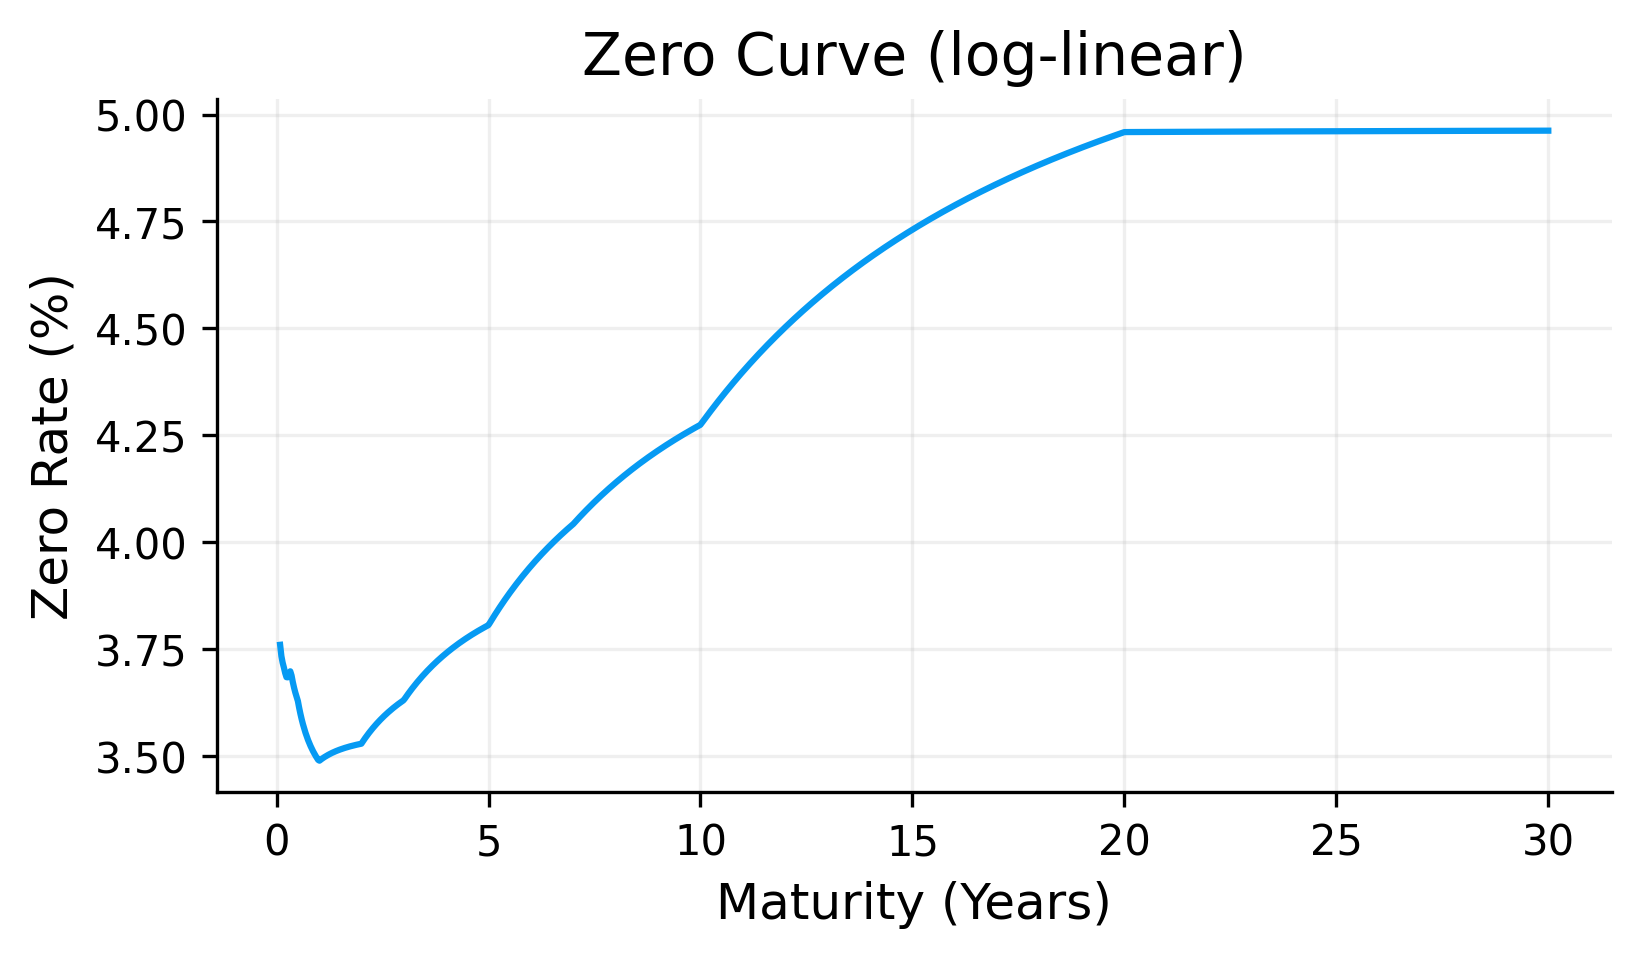

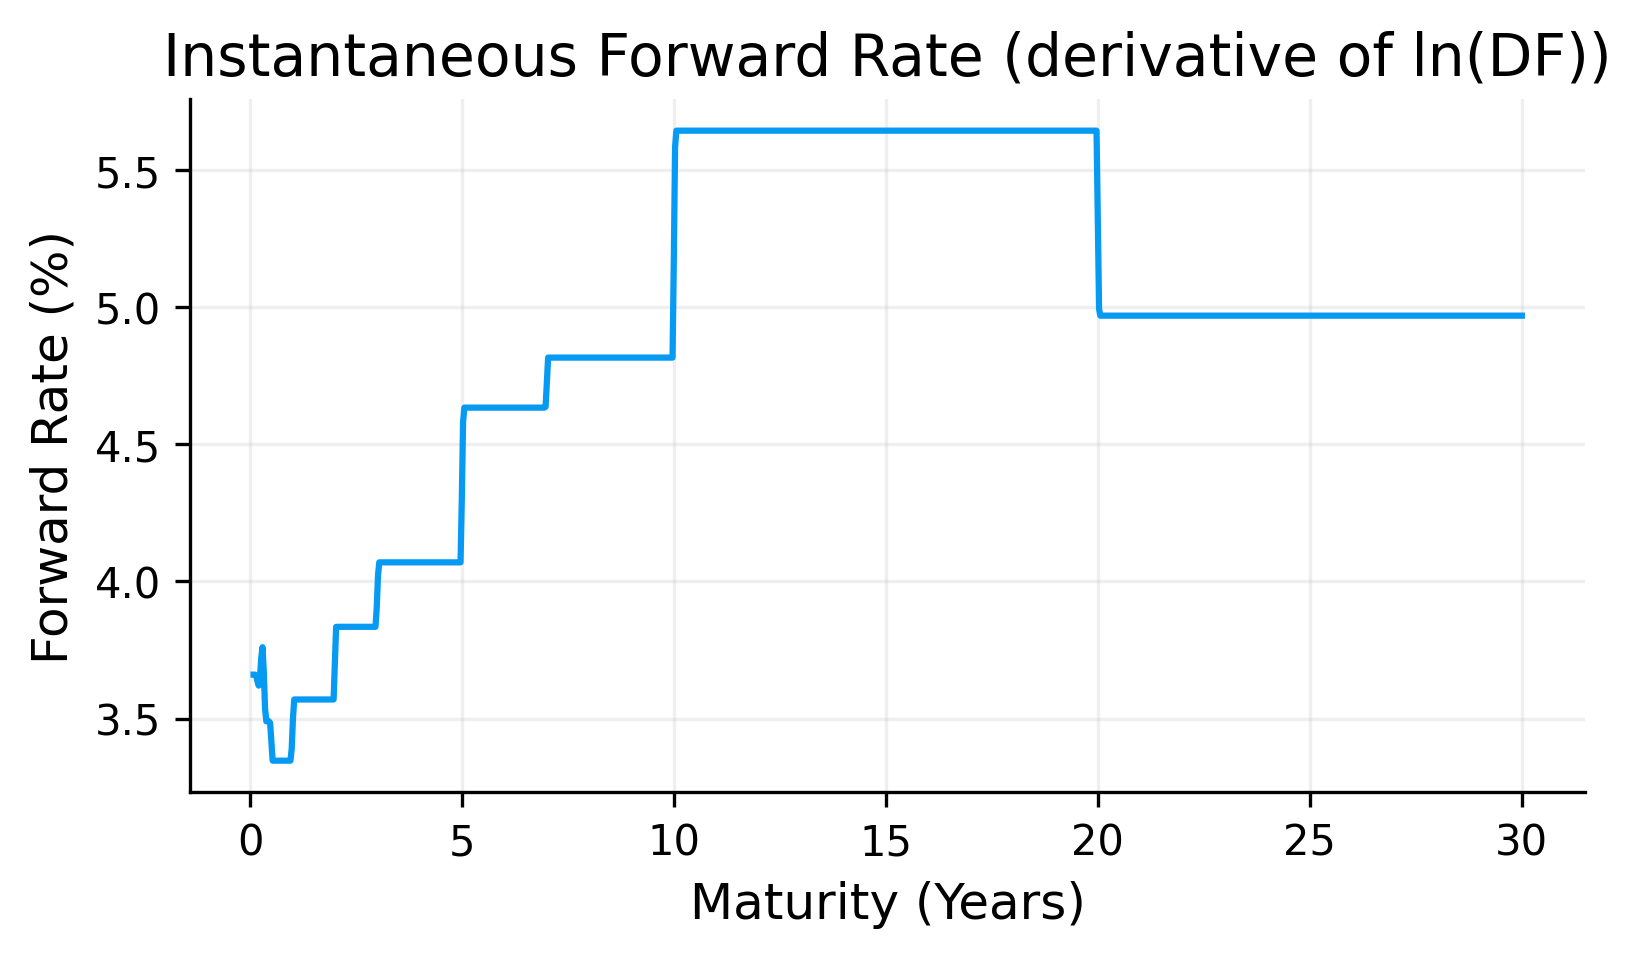

In [6]:
def loglinear_curve(T, dfs):
    loglinear_log_dfs = np.log(dfs)

    loglinear_grid = np.linspace(max(1 / 12, T.min()), 30.0, 1000)
    loglinear_log_df_grid = np.interp(
        loglinear_grid,
        T,
        loglinear_log_dfs,
        left=loglinear_log_dfs[0],
        right=loglinear_log_dfs[-1],
    )
    loglinear_df_grid = np.exp(loglinear_log_df_grid)

    # zero rate
    loglinear_z_grid = -np.log(loglinear_df_grid) / loglinear_grid

    # instantaneous forward rate
    loglinear_fwd_grid = -np.gradient(np.log(loglinear_df_grid), loglinear_grid)

    def loglinear_df_func(t):
        t = np.array(t, dtype=float)
        log_df = np.interp(
            t,
            T,
            loglinear_log_dfs,
            left=loglinear_log_dfs[0],
            right=loglinear_log_dfs[-1],
        )
        return np.exp(log_df)

    return {
        "name": "Log-linear DF",
        "grid": loglinear_grid,
        "df_grid": loglinear_df_grid,
        "z_grid": loglinear_z_grid,
        "fwd_grid": loglinear_fwd_grid,
        "df_func": loglinear_df_func,
        "log_dfs": loglinear_log_dfs,
    }


loglinear_curve_data = loglinear_curve(T, dfs)
loglinear_grid = loglinear_curve_data["grid"]
loglinear_df_grid = loglinear_curve_data["df_grid"]
loglinear_z_grid = loglinear_curve_data["z_grid"]
loglinear_fwd_grid = loglinear_curve_data["fwd_grid"]

if "curves" not in globals():
    curves = {}
curves["loglinear"] = loglinear_curve_data


plt.figure()
plt.plot(loglinear_grid, loglinear_z_grid * 100.0)
plt.title("Zero Curve (log-linear)")
plt.xlabel("Maturity (Years)")
plt.ylabel("Zero Rate (%)")
plt.show()

plt.figure()
plt.plot(loglinear_grid, loglinear_fwd_grid * 100.0)
plt.title("Instantaneous Forward Rate (derivative of ln(DF))")
plt.xlabel("Maturity (Years)")
plt.ylabel("Forward Rate (%)")
plt.show()


## 7) Curve Models Using Zero-Rate Smoothing

Instead of interpolating $D$, we can interpolate $z$ and recover $D(t)=e^{-z(t)t}$.

### 7.1 PCHIP on zero rates (Piecewise Cubic Hermite Interpolating Polynomial)
Given nodes $x_j=T_j$ and $y_j=z(T_j)$, PCHIP builds a piecewise cubic polynomial on each interval:

$$
p_j(t)=a_j(t-x_j)^3+b_j(t-x_j)^2+c_j(t-x_j)+d_j  \quad t\in[x_j,x_{j+1}]
$$

Constraints include:
- $p_j(x_j)=y_j$ and $p_j(x_{j+1})=y_{j+1}$
- first derivatives are chosen by shape-preserving slope rules to reduce overshoot

we define
$z(t)=p_j(t)$

then
$D(t)=e^{-z(t)t}$



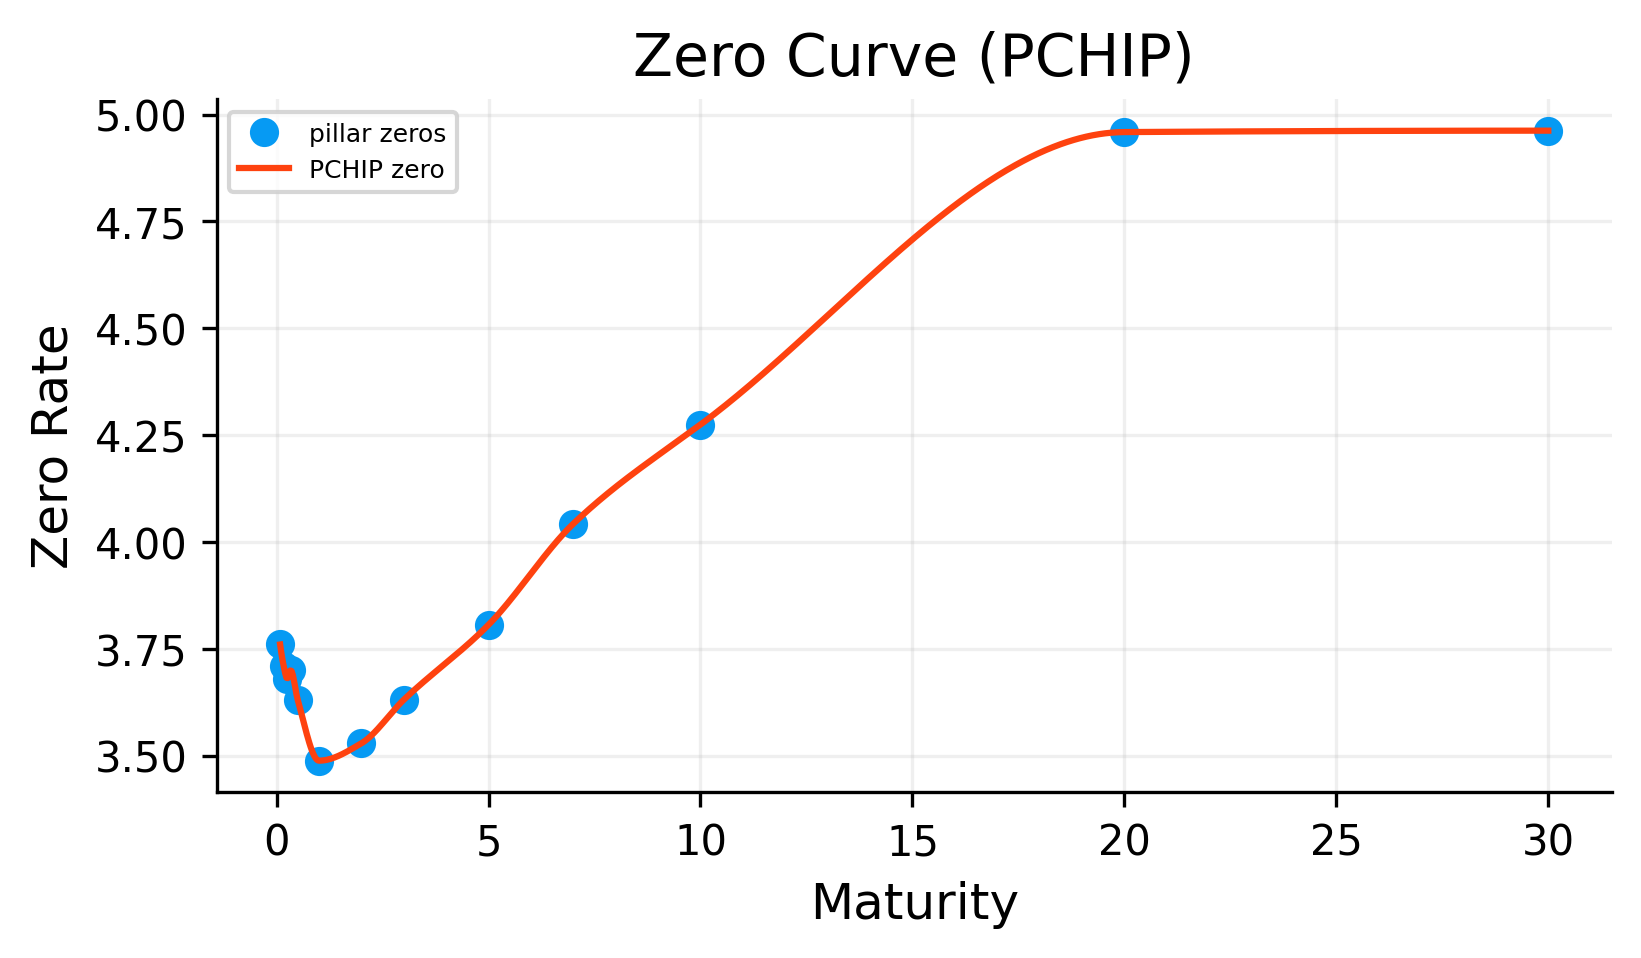

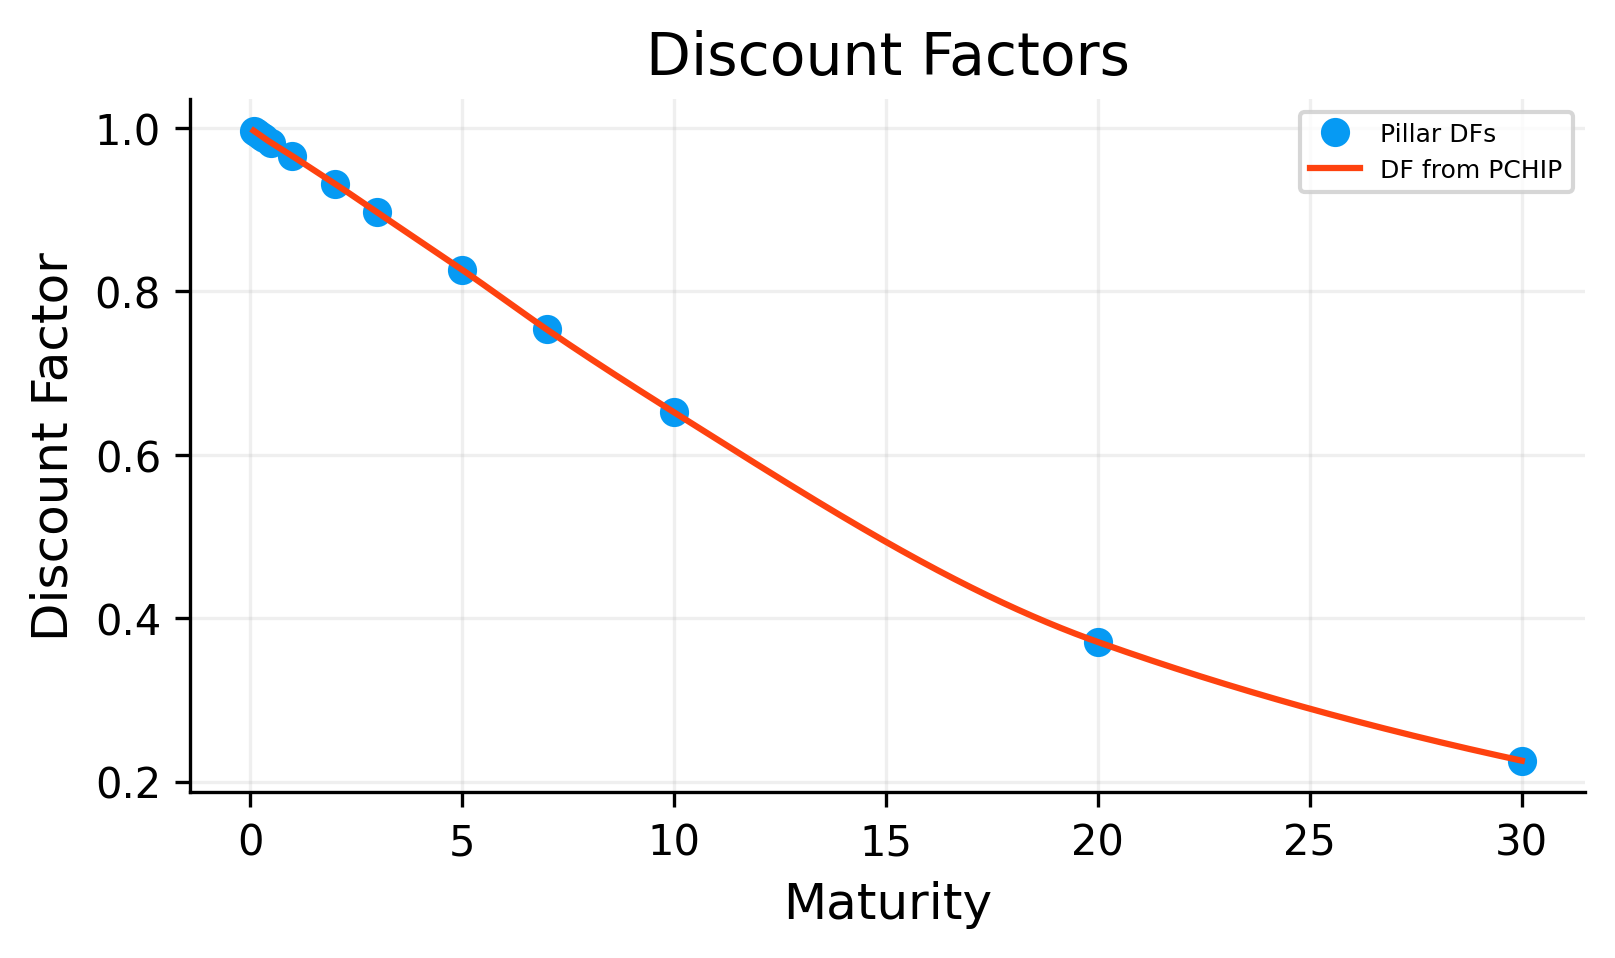

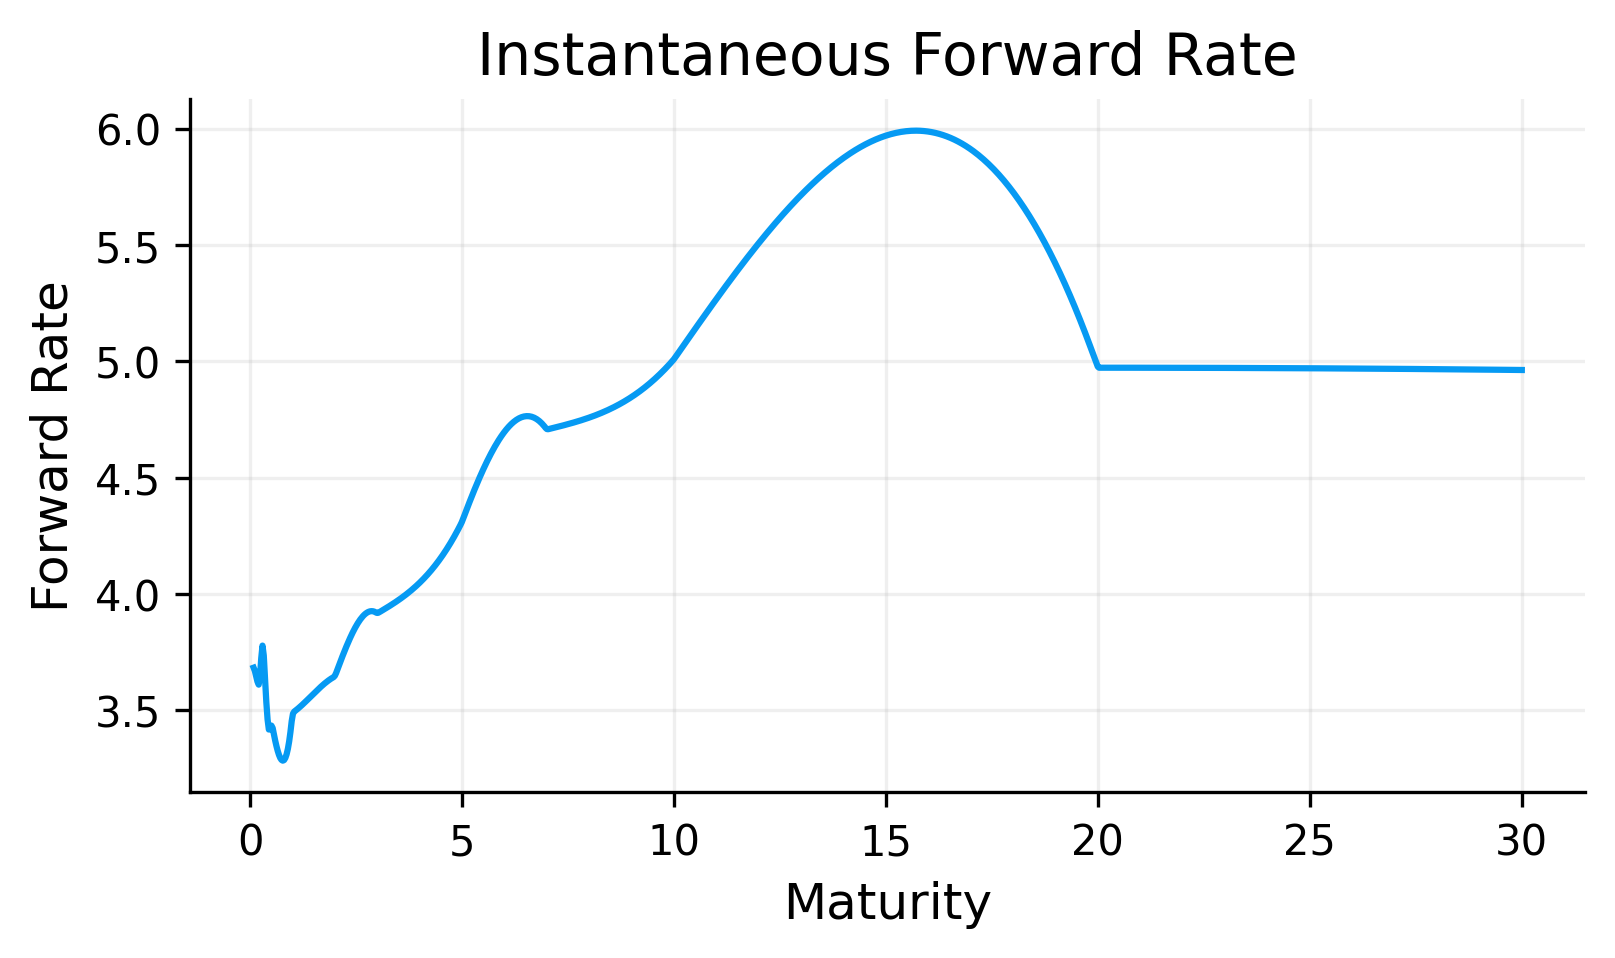

In [7]:
from scipy.interpolate import PchipInterpolator


def pchip_curve(T, dfs):
    pchip_zeros = -np.log(np.clip(dfs, min_d, None)) / T

    pchip_z = PchipInterpolator(T, pchip_zeros, extrapolate=True)
    pchip_grid = np.linspace(max(1 / 12, T.min()), 30.0, 1000)
    pchip_z_grid = pchip_z(pchip_grid)
    pchip_df_grid = np.exp(-pchip_z_grid * pchip_grid)

    pchip_fwd_grid = -np.gradient(
        np.log(np.clip(pchip_df_grid, min_d, None)), pchip_grid
    )

    def pchip_df_func(t):
        t = np.array(t, dtype=float)
        z = pchip_z(t)
        return np.exp(-z * t)

    return {
        "name": "PCHIP zero",
        "grid": pchip_grid,
        "df_grid": pchip_df_grid,
        "z_grid": pchip_z_grid,
        "fwd_grid": pchip_fwd_grid,
        "df_func": pchip_df_func,
        "pillar_zeros": pchip_zeros,
    }


pchip_curve_data = pchip_curve(T, dfs)
curves["pchip"] = pchip_curve_data


plt.figure()
plt.plot(T, pchip_curve_data["pillar_zeros"] * 100.0, "o", label="pillar zeros")
plt.plot(pchip_curve_data["grid"], pchip_curve_data["z_grid"] * 100.0, "-", label="PCHIP zero")
plt.title("Zero Curve (PCHIP)")
plt.xlabel("Maturity")
plt.ylabel("Zero Rate")
plt.legend()
plt.show()

plt.figure()
plt.plot(T, dfs, "o", label="Pillar DFs")
plt.plot(pchip_curve_data["grid"], pchip_curve_data["df_grid"], "-", label="DF from PCHIP")
plt.title("Discount Factors")
plt.xlabel("Maturity")
plt.ylabel("Discount Factor")
plt.legend()
plt.show()

plt.figure()
plt.plot(pchip_curve_data["grid"], pchip_curve_data["fwd_grid"] * 100.0)
plt.title("Instantaneous Forward Rate")
plt.xlabel("Maturity")
plt.ylabel("Forward Rate")
plt.show()


## 8) Nelson–Siegel–Svensson (NSS) yield curve

we represent the continuous-compounded zero rate curve $z(t)$ with a small number of parameters, then derive discount factors, par yields and forwards

### 8.1 NSS zero-rate function

For maturity $t>0$, the NSS zero rate is:

$$
z(t)=\beta_0 +\beta_1\left(\frac{1-e^{-t/\tau_1}}{t/\tau_1}\right) +\beta_2\left(\frac{1-e^{-t/\tau_1}}{t/\tau_1}-e^{-t/\tau_1}\right) +\beta_3\left(\frac{1-e^{-t/\tau_2}}{t/\tau_2}-e^{-t/\tau_2}\right)
$$

Parameters:

- $\beta_0$ = long-run “level”

- $\beta_1$ = “slope” (short-end effect)

- $\beta_2$ = medium-term “curvature” (first hump)

- $\beta_3$ = additional curvature (second hump)

- $\tau_1,\tau_2>0$ control where humps occur

In [8]:
def nss_zero(t, b0,b1,b2,b3,tau1,tau2):
    t = np.array(t, dtype=float)
    x1 = t / tau1
    x2 = t / tau2
    L1 = (1.0 - np.exp(-x1)) / x1
    C1 = L1 - np.exp(-x1)
    C2 = (1.0 - np.exp(-x2)) / x2 - np.exp(-x2)
    return b0 + b1*L1 + b2*C1 + b3*C2


### 8.3 Par yield implied by NSS

For a coupon bond with maturity $T$ and coupon frequency $f$, coupon rate $c(T)$ is the rate that makes the bond price equal to par (normalize notional to 1):

$$
1=\sum_{i=1}^{n}\frac{c(T)}{f}D(t_i)+D(T)
$$

Solve for $c(T)$:

$$
c(T)=f\cdot\frac{1-D(T)}{\sum_{i=1}^{n}D(t_i)}
$$


For short maturities (money-market style), a common mapping is:

continuous: $y(T)=-\ln D(T)/T$

simple: $y(T)=(1/D(T)-1)/T$

but first we have to have $D(t)$

In [9]:
def par_from_d(df_func, T_list, f=2):
    T_arr = np.asarray(T_list, dtype=float)
    out = np.full_like(T_arr, np.nan, dtype=float)

    step = 1.0 / float(f)

    for k, Tk in enumerate(T_arr):
        if not np.isfinite(Tk) or Tk <= 0:
            continue

        D_T = float(np.asarray(df_func([Tk],), dtype=float)[0])
        D_T = max(D_T, min_d)

        if Tk < 1.0:
            if short_end_convention == "simple":
                out[k] = (1.0 / D_T - 1.0) / Tk
            else:
                out[k] = -np.log(D_T) / Tk
            continue

        n_full = int(np.floor(Tk * f + 1e-12))
        times = np.arange(step, n_full * step + 1e-12, step)
        if len(times) == 0 or abs(times[-1] - Tk) > 1e-10:
            times = np.append(times, Tk)

        accr = np.diff(np.concatenate([[0.0], times]))
        dfs = np.asarray(df_func(times), dtype=float)
        dfs = np.clip(dfs, min_d, None)

        denom = float(np.sum(accr * dfs))
        out[k] = (1.0 - dfs[-1]) / denom if denom > 0 else np.nan

    return out


### 8.2 Discount factor and forward from NSS

Once we have $z(t)$, using continuous compounding:

$D(t)=e^{-z(t)t}$

and the instantaneous forward rate is:

$f(t)=-\frac{d}{dt}\ln D(t)$

With NSS you often compute $f(t)$ numerically on a grid:
$$f(t_i)\approx -\frac{\ln D(t_{i+1})-\ln D(t_{i-1})}{t_{i+1}-t_{i-1}}
$$

---

### 8.4 Calibrating NSS to market par yields

Given observed par yields $y^{mkt}(T_j)$ at tenors $T_j$, we choose parameters
$\theta=(\beta_0,\beta_1,\beta_2,\beta_3,\tau_1,\tau_2)$ to minimize a least-squares objective:

$$\min_{\theta}\sum_{j}\left(c^{model}(T_j;\theta)-y^{mkt}(T_j)\right)^2
$$

Optionally add regularization to discourage extreme shapes:
$\lambda\sum_j (z''(t_j))^2$ or bounds on parameters.

final MSE: 3.5093289069366877e-07
theta = [b0,b1,b2,b3,tau1,tau2] = [ 0.053115 -0.014698 -0.031572 -0.007968  1.500251  5.000021]


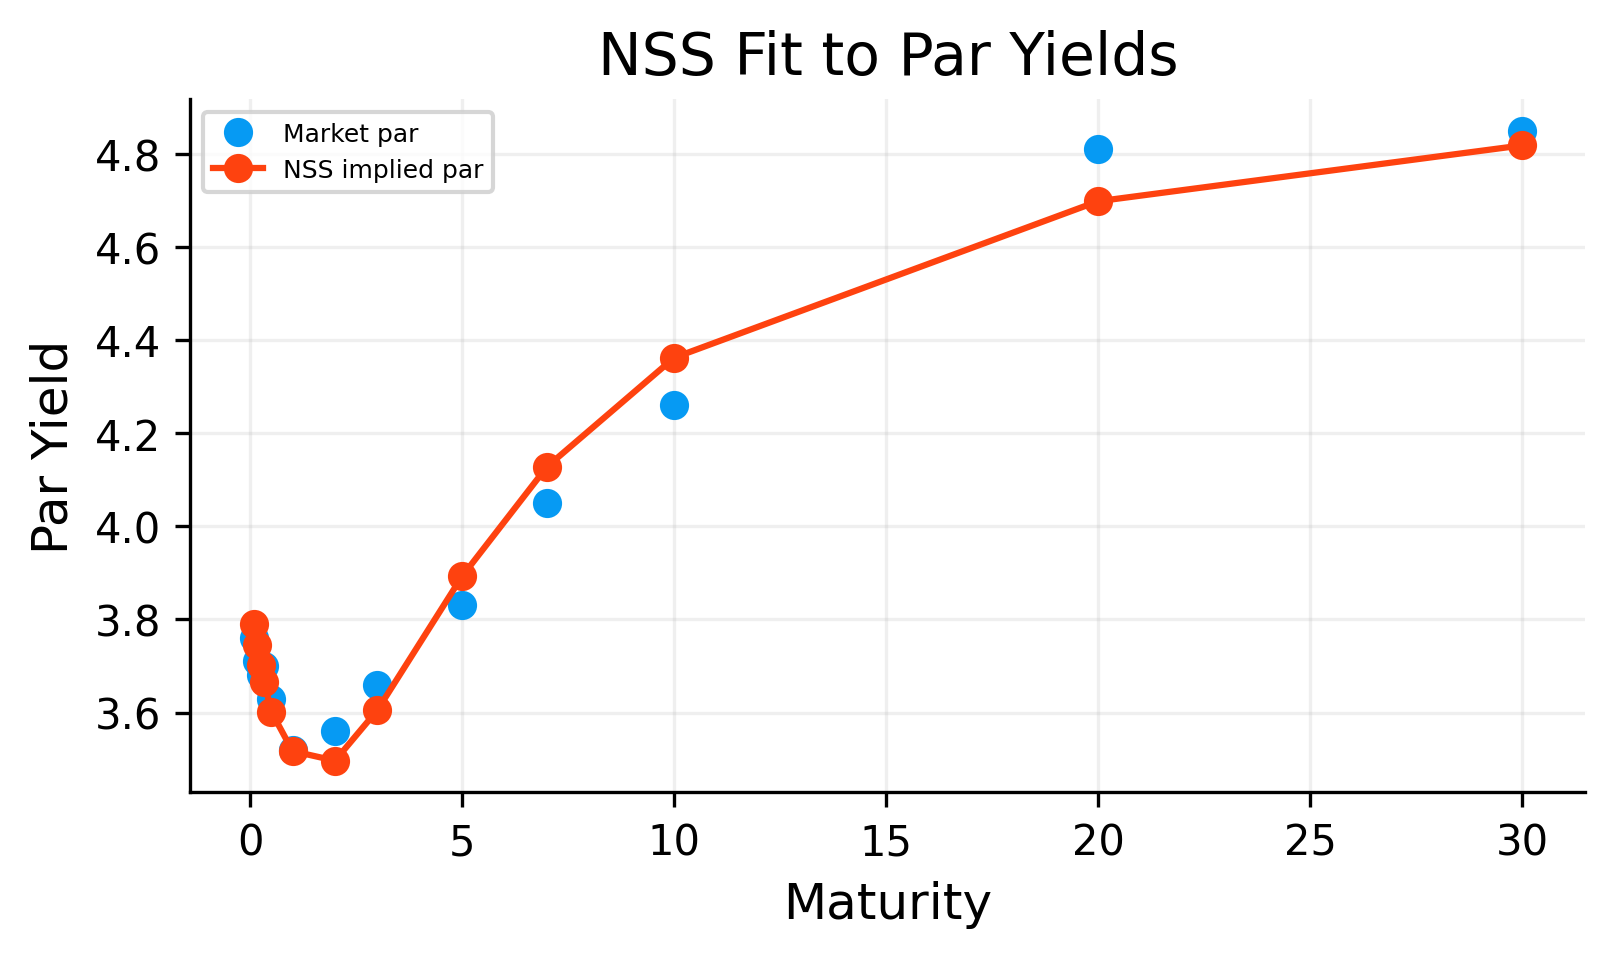

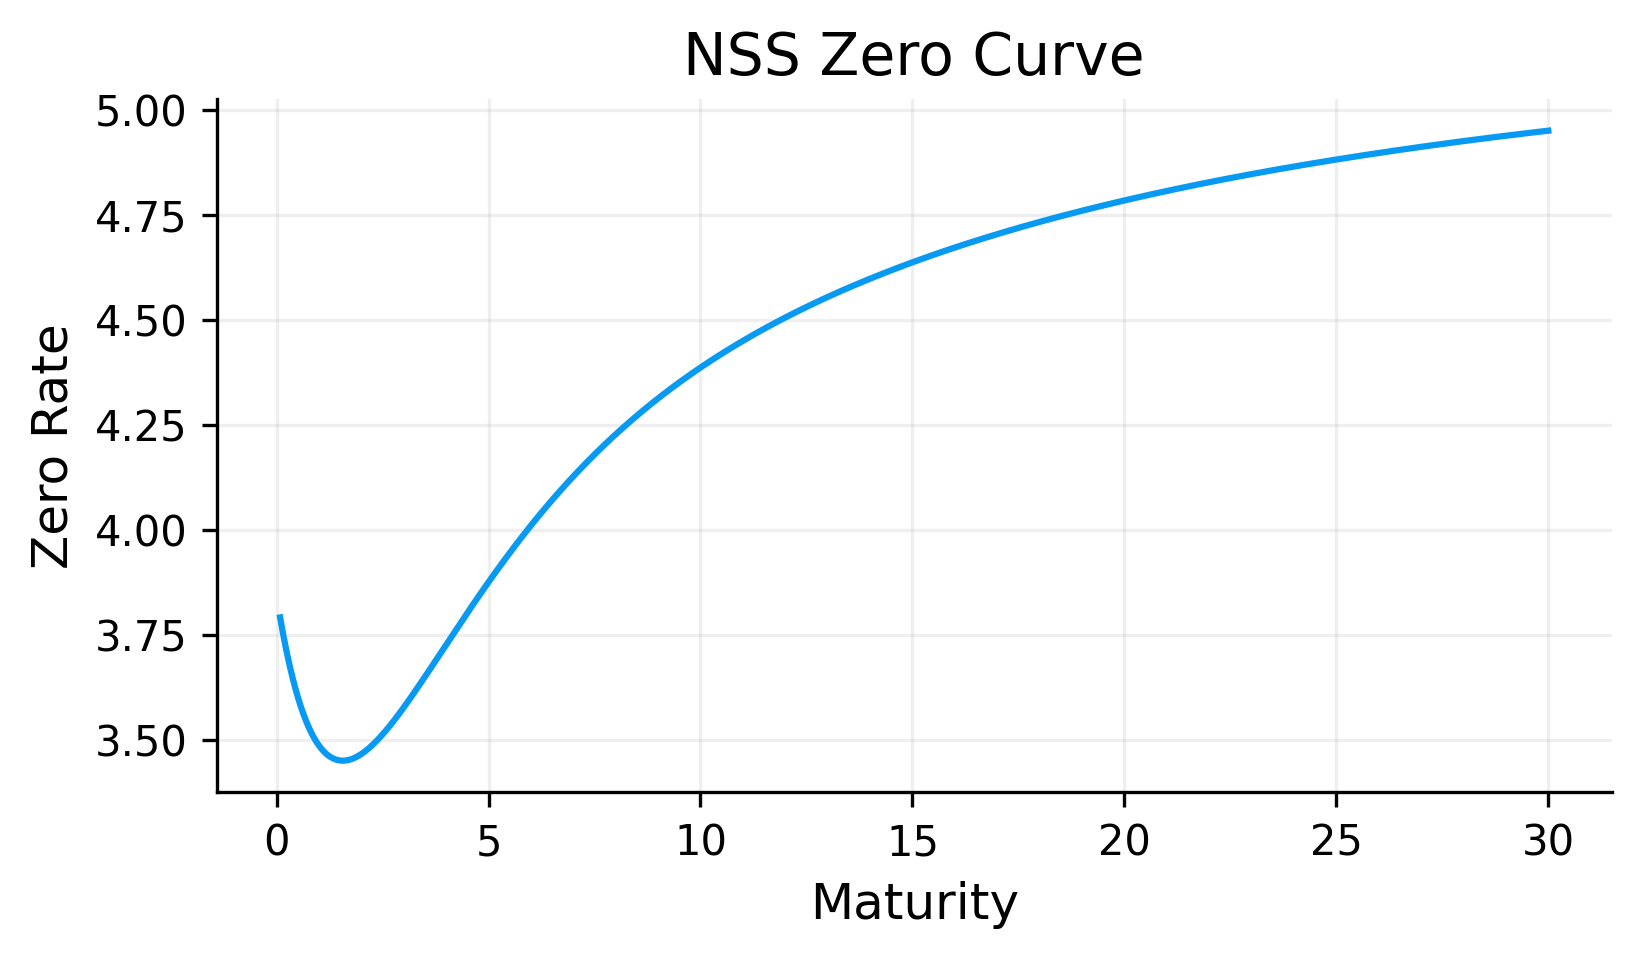

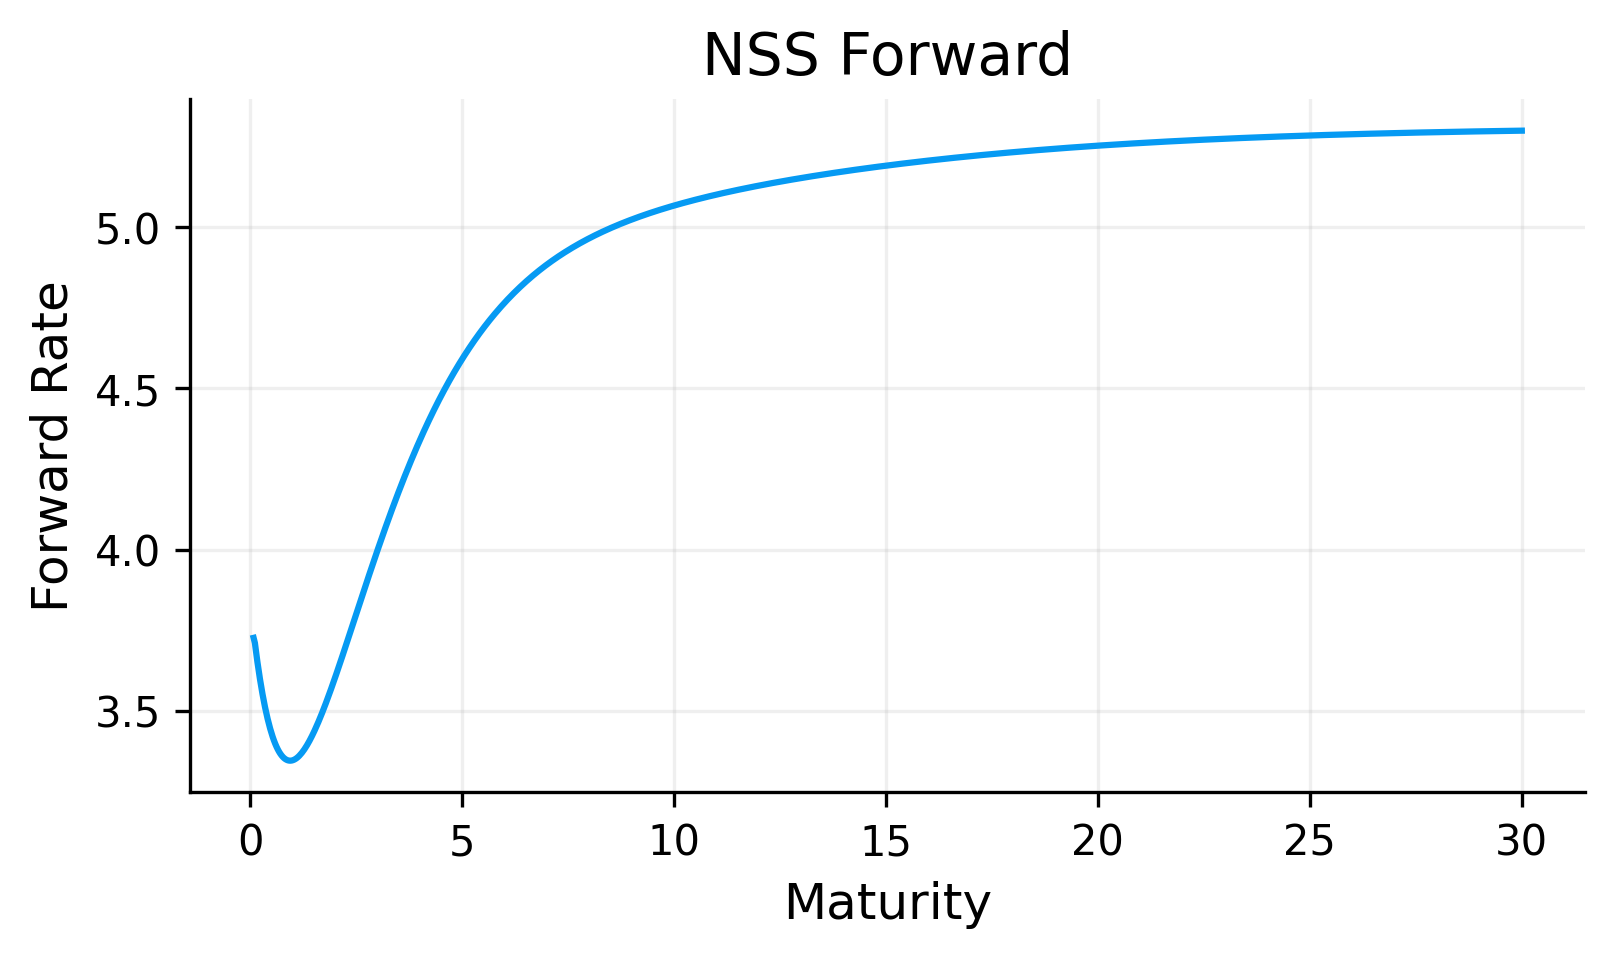

In [10]:
from scipy.optimize import minimize


def nss_curve(T, par):
    def obj(theta):
        b0, b1, b2, b3, tau1, tau2 = theta
        z = nss_zero(T, b0, b1, b2, b3, tau1, tau2)
        dfs = np.exp(-z * T)

        # we use log-linear DF interpolation on pillars for keeping it positive
        log_dfs = np.log(np.clip(dfs, min_d, None))

        def df_func(t):
            t = np.array(t, dtype=float)
            log_df = np.interp(t, T, log_dfs, left=log_dfs[0], right=log_dfs[-1])
            return np.exp(log_df)

        par_model = par_from_d(df_func, T)
        err = par_model - par
        return float(np.mean(err**2))

    # initializing with a first guess. for long run level we need something like the long-run yield level. that's why we use long term yields as guess
    b0_0 = float(np.nanmedian(par[-3:])) if len(par) >= 3 else float(np.nanmedian(par))
    x0 = np.array([b0_0, -0.02, 0.02, 0.01, 1.5, 5.0], dtype=float)

    # we use a type of quasi-Newton method for nonlinear optimization of parameters
    pred = minimize(obj, x0, method="L-BFGS-B")
    theta = pred.x

    nss_grid = np.linspace(max(1 / 12, T.min()), 30.0, 1000)
    nss_z_grid = nss_zero(nss_grid, *theta)
    nss_df_grid = np.exp(-nss_z_grid * nss_grid)

    nss_fwd_grid = -np.gradient(
        np.log(np.clip(nss_df_grid, min_d, None)), nss_grid
    )

    def nss_df_func(t):
        t = np.array(t, dtype=float)
        return np.exp(-nss_zero(t, *theta) * t)

    curve = {
        "name": "NSS",
        "grid": nss_grid,
        "df_grid": nss_df_grid,
        "z_grid": nss_z_grid,
        "fwd_grid": nss_fwd_grid,
        "df_func": nss_df_func,
        "theta": theta,
    }


    z_p = nss_zero(T, *theta)
    d_p = np.exp(-z_p * T)
    log_d_p = np.log(np.clip(d_p, min_d, None))
    def df_func_p(tt):
        return np.exp(
            np.interp(np.array(tt, float), T, log_d_p, left=log_d_p[0], right=log_d_p[-1])
        )
    par_fit = par_from_d(df_func_p, T)

    return curve, par_fit, pred


nss_curve_data, par_fit, pred = nss_curve(T, par)
theta = nss_curve_data["theta"]

if "curves" not in globals():
    curves = {}
curves["nss"] = nss_curve_data

print("final MSE:", pred.fun)
print("theta = [b0,b1,b2,b3,tau1,tau2] =", np.round(theta, 6))

plt.figure()
plt.plot(T, par * 100.0, "o", label="Market par")
plt.plot(T, par_fit * 100.0, "-o", label="NSS implied par")
plt.title("NSS Fit to Par Yields")
plt.xlabel("Maturity")
plt.ylabel("Par Yield")
plt.legend()
plt.show()

plt.figure()
plt.plot(nss_curve_data["grid"], nss_curve_data["z_grid"] * 100.0)
plt.title("NSS Zero Curve")
plt.xlabel("Maturity")
plt.ylabel("Zero Rate")
plt.show()

plt.figure()
plt.plot(nss_curve_data["grid"], nss_curve_data["fwd_grid"] * 100.0)
plt.title("NSS Forward")
plt.xlabel("Maturity")
plt.ylabel("Forward Rate")
plt.show()


## 9) QP curve: smooth discount factors under exact par-bond fit

Another approach for building a yield curve that:

- matches par-bond pricing equations exactly (like bootstrapping) or near-exactly (like NSS),

- is smooth,

- will result in a positive and increasing DF curve.

can come from a Quadratic Program (QP) if the variables are discount factors on a grid and constraints are linear.

### 9.1 Variables

We Pick a grid of cashflow times (like semiannual up to 30Y):
$t_1,t_2,\dots,t_M$

we want to get to 
$$
\mathbf{d} = (D(t_1),\dots,D(t_M))
$$

### 9.2 constraints

For a maturity $T$ (present on the grid), par yield $c$ and frequency $f$:

$$
1=\sum_{i=1}^{n}\frac{c}{f}D(t_i)+D(T)
$$

This is linear in $D(\cdot)$, so it becomes one row of:
$A\mathbf{d}=\mathbf{1}$

Positivity: $D(t_k)\ge D_{min}$

Monotone decreasing: $D(t_{k+1})\le D(t_k)$

These are linear inequalities, so the problem stays convex and QP-solvable.

In [11]:
import cvxpy as cp


def qp_build_t_grid(T_obs, f):
    T_max = float(np.max(T_obs))
    n_grid = int(round(T_max * f))
    t_grid = np.unique(
        np.concatenate(
            [
                np.array([i / f for i in range(1, n_grid + 1)], dtype=float),
                T_obs,
            ]
        )
    )
    t_grid = np.array(sorted(t_grid), dtype=float)
    grid_index = {float(np.round(t, 10)): i for i, t in enumerate(t_grid)}
    return t_grid, grid_index


def qp_build_constraints(t_grid, grid_index, T_obs, par_mkt, f, min_d):
    d = cp.Variable(len(t_grid))

    constraints = []
    constraints += [d >= min_d]
    constraints += [d[1:] <= d[:-1]]

    for Tk, yk in zip(T_obs, par_mkt, strict=True):
        if Tk < 1.0:
            key = float(np.round(Tk, 10))
            if key in grid_index:
                i = grid_index[key]
                df_target = float(np.exp(-yk * Tk))
                constraints += [d[i] == df_target]

    for Tk, ck in zip(T_obs, par_mkt, strict=True):
        if Tk < 1.0:
            continue
        keyT = float(np.round(Tk, 10))
        if keyT not in grid_index:
            continue
        iT = grid_index[keyT]
        n = int(round(Tk * f))

        coupon_idx = []
        for j in range(1, n + 1):
            key = float(np.round(j / f, 10))
            coupon_idx.append(grid_index[key])

        constraints += [cp.sum((ck / f) * d[coupon_idx]) + d[iT] == 1.0]

    return d, constraints





### 9.3 Smoothness objective (quadratic)

A simple convex smoothness penalty is the squared second difference of Discount Factors:

$\min_{\mathbf{d}} \ |\Delta^2\mathbf{d}|_2^2$

where $\Delta^2 d_k = d_{k+2}-2d_{k+1}+d_k$. (Discrete version)

This makes the optimizer prefer sequences of discount factors that have small curvature everywhere, which results a smooth DF curve with fewer oscillations and jumps.

we can also add a mild “keep close to a prior curve” penalty:
$\epsilon|\mathbf{d}-\mathbf{d}^{prior}|_2^2$ 

Total objective:
$\min_{\mathbf{d}} \ \lambda|\Delta^2\mathbf{d}|_2^2 + \epsilon|\mathbf{d}-\mathbf{d}^{prior}|_2^2$

### 9.4 zero and forward curves

Once we have $D(t)$ on a grid:

$z(t_k)=-\ln D(t_k)/t_k$

$f(t_k)\approx -\dfrac{\ln D(t_{k+1})-\ln D(t_k)}{t_{k+1}-t_k}$

status: optimal ,  value: 1.2368745747617473


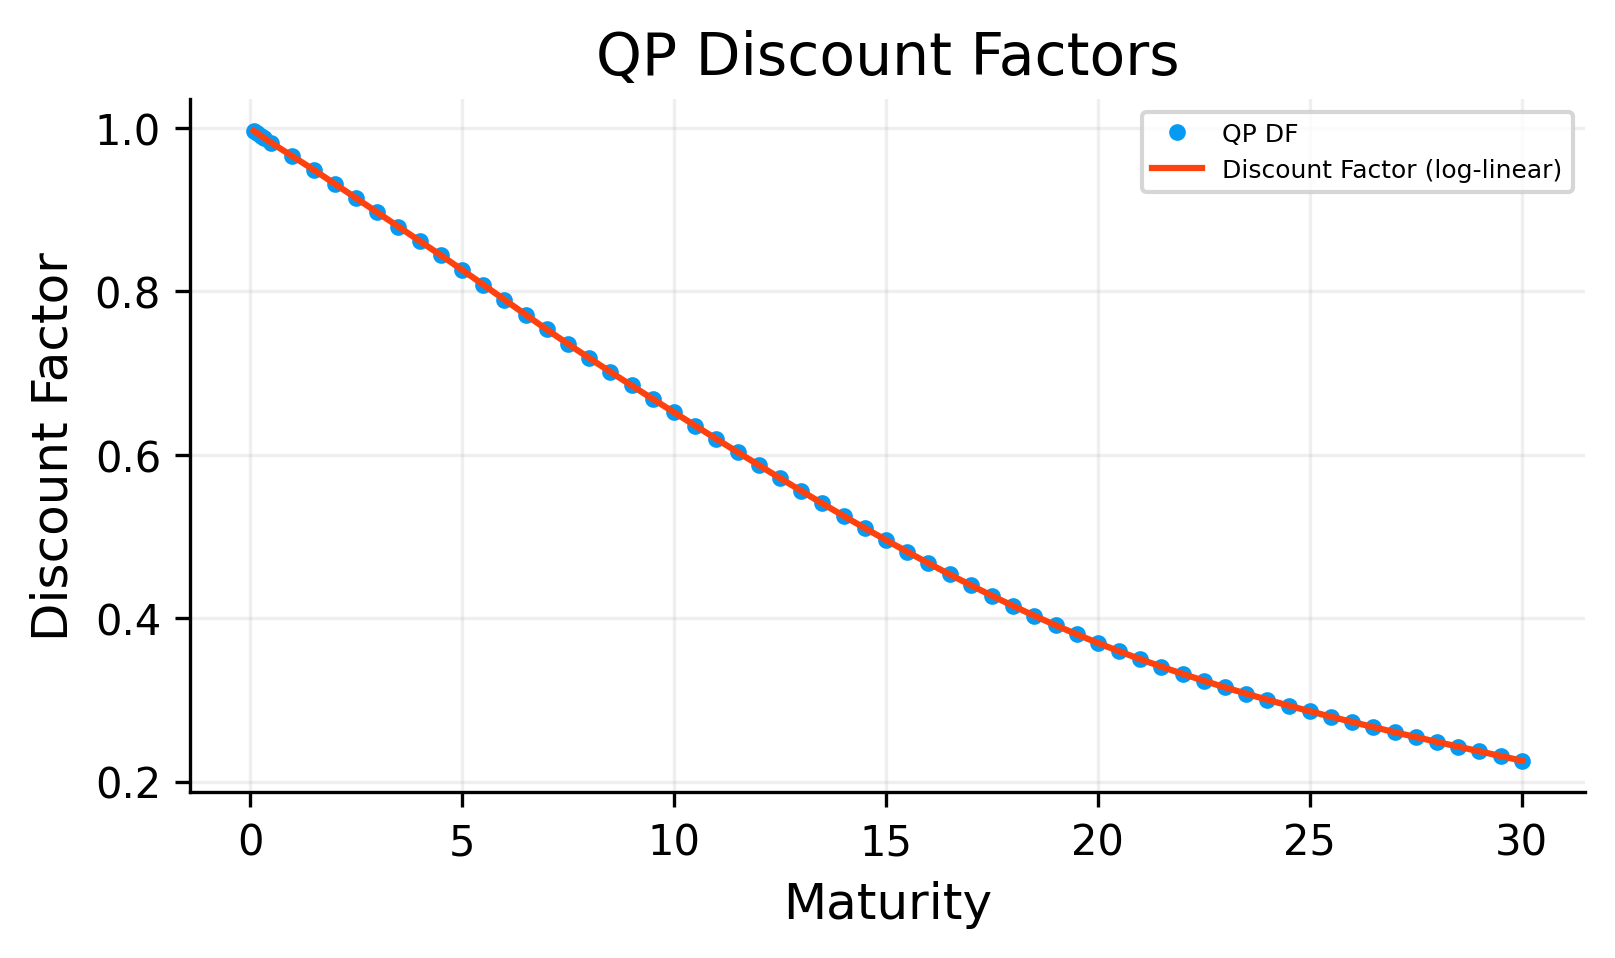

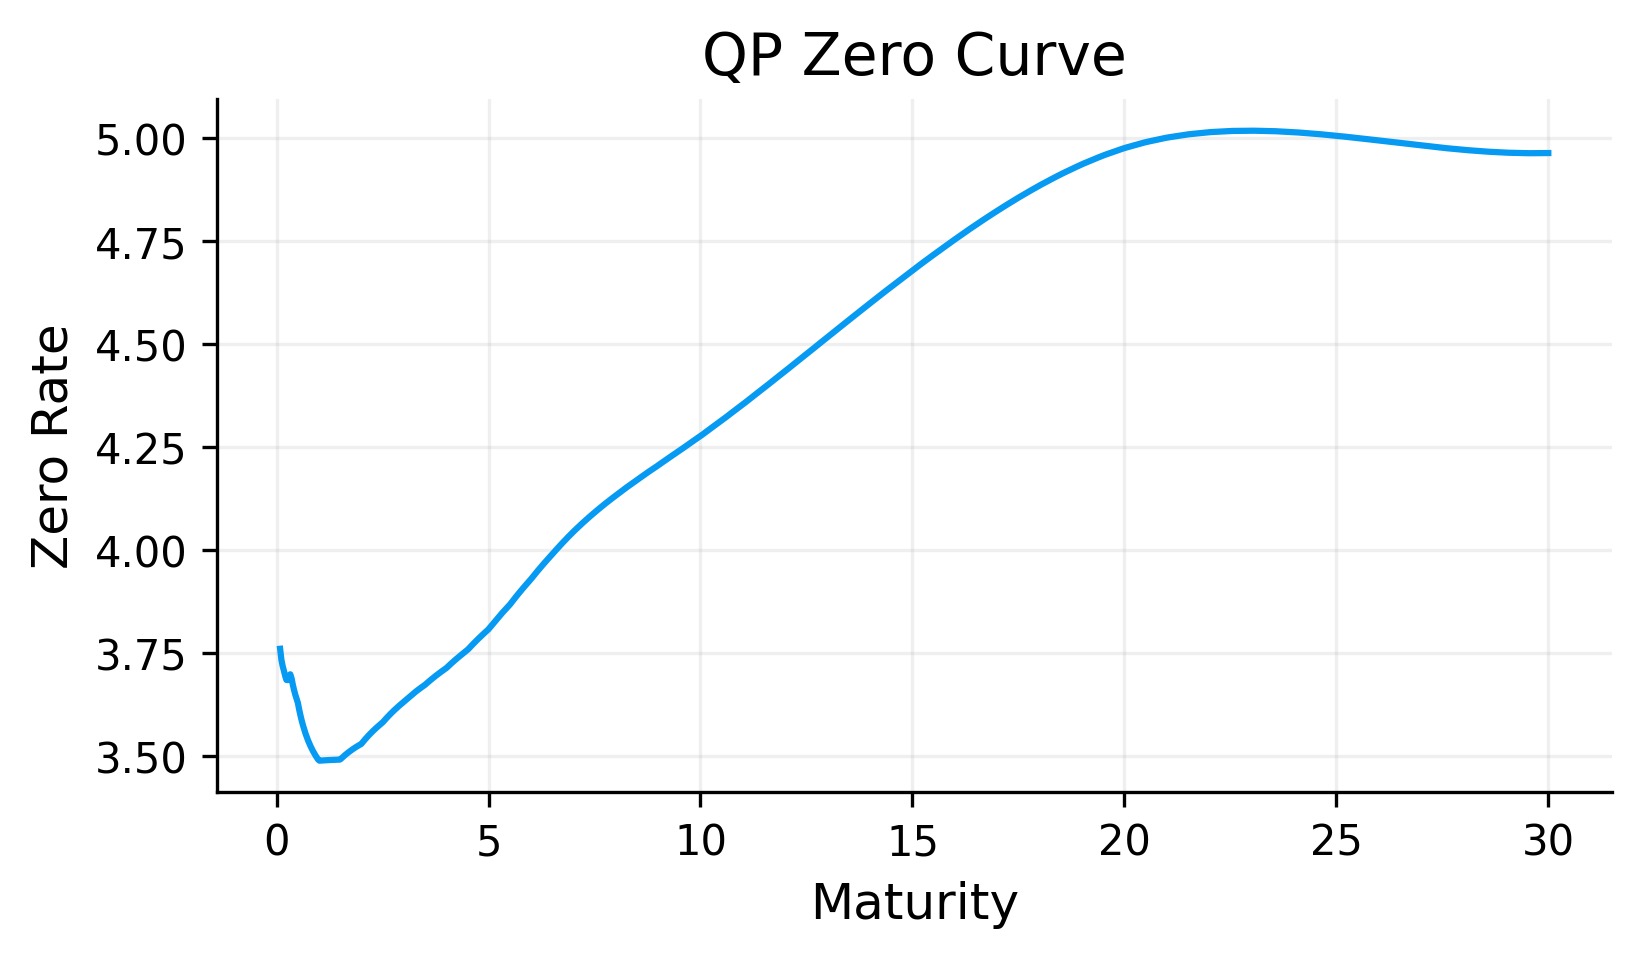

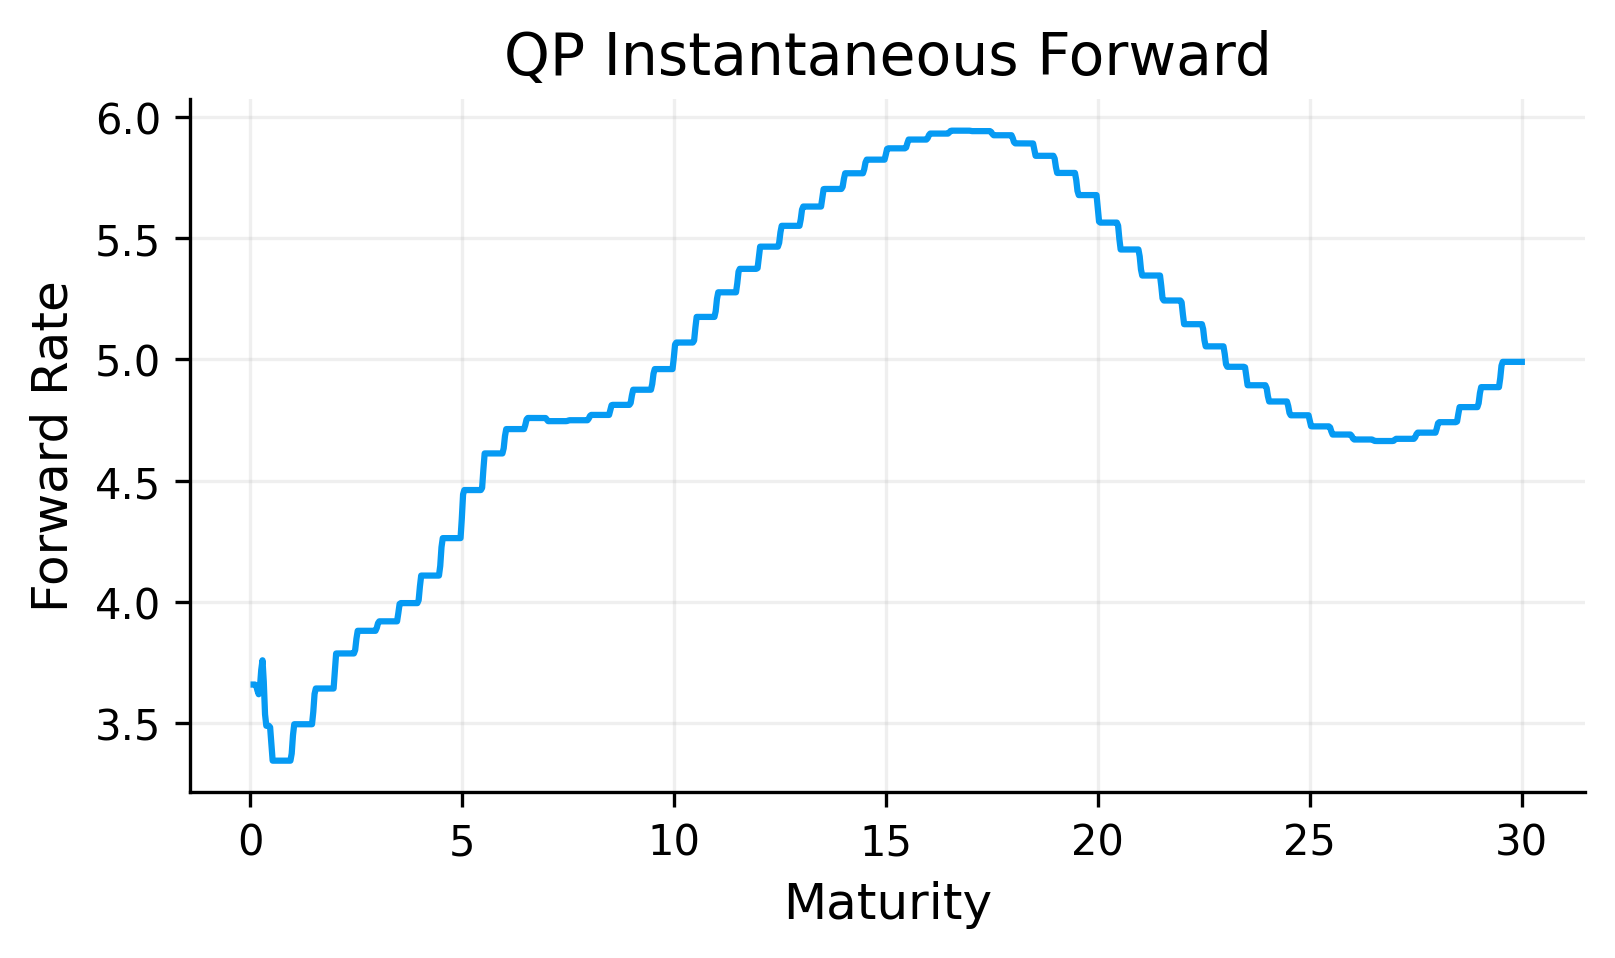

In [12]:
def qp_solve(t_grid, d, constraints, par_mkt, f, min_d):
    lam = 1e4
    eps = 1e-4
    prior_rate = (
        float(np.nanmedian(par_mkt[-3:])) if len(par_mkt) >= 3 else float(np.nanmedian(par_mkt))
    )
    d_prior = np.exp(-prior_rate * t_grid)

    d2 = d[2:] - 2 * d[1:-1] + d[:-2]
    obj = cp.Minimize(lam * cp.sum_squares(d2) + eps * cp.sum_squares(d - d_prior))

    prog = cp.Problem(obj, constraints)
    prog.solve(solver=cp.OSQP)

    d_sol = np.array(d.value).astype(float)
    d_sol = np.clip(d_sol, min_d, None)

    return d_sol, prog.status, prog.value


def qp_build_curve(t_grid, d_sol):
    qp_grid = np.linspace(max(1 / 12, t_grid.min()), 30.0, 1000)
    qp_log_d = np.log(d_sol)
    qp_log_df_grid = np.interp(qp_grid, t_grid, qp_log_d, left=qp_log_d[0], right=qp_log_d[-1])

    qp_df_grid = np.exp(qp_log_df_grid)
    qp_z_grid = -np.log(qp_df_grid) / np.maximum(qp_grid, 1e-8)
    qp_fwd_grid = -np.gradient(np.log(qp_df_grid), qp_grid)

    def qp_df_func(t):
        t = np.array(t, dtype=float)
        log_df = np.interp(t, t_grid, qp_log_d, left=qp_log_d[0], right=qp_log_d[-1])
        return np.exp(log_df)

    curve = {
        "name": "QP DF",
        "grid": qp_grid,
        "df_grid": qp_df_grid,
        "z_grid": qp_z_grid,
        "fwd_grid": qp_fwd_grid,
        "df_func": qp_df_func,
    }

    return curve


def qp_curve(labels, par_mkt, f=2, min_d=1e-10):
    T_obs = []
    for lab in labels:
        labu = lab.upper().strip()
        T_obs.append(int(labu[:-1]) / 12.0 if labu.endswith("M") else float(int(labu[:-1])))
    T_obs = np.array(T_obs, dtype=float)

    idx = np.argsort(T_obs)
    T_obs = T_obs[idx]
    par_mkt = par_mkt[idx]
    labels = [labels[i] for i in idx]

    t_grid, grid_index = qp_build_t_grid(T_obs, f)
    d, constraints = qp_build_constraints(t_grid, grid_index, T_obs, par_mkt, f, min_d)
    d_sol, status, value = qp_solve(t_grid, d, constraints, par_mkt, f, min_d)

    curve = qp_build_curve(t_grid, d_sol)

    state = {
        "t_grid": t_grid,
        "d_sol": d_sol,
        "constraints": constraints,
        "status": status,
        "value": value,
    }

    return curve, state


qp_curve_data, qp_state = qp_curve(labels, par)

curves["qp"] = qp_curve_data

print("status:", qp_state["status"], ",  value:", qp_state["value"])


plt.figure()
plt.plot(qp_state["t_grid"], qp_state["d_sol"], "o", markersize=3, label="QP DF")
plt.plot(qp_curve_data["grid"], qp_curve_data["df_grid"], "-", label="Discount Factor (log-linear)")
plt.title("QP Discount Factors")
plt.xlabel("Maturity")
plt.ylabel("Discount Factor")
plt.legend()
plt.show()

plt.figure()
plt.plot(qp_curve_data["grid"], qp_curve_data["z_grid"] * 100.0)
plt.title("QP Zero Curve")
plt.xlabel("Maturity")
plt.ylabel("Zero Rate")
plt.show()

plt.figure()
plt.plot(qp_curve_data["grid"], qp_curve_data["fwd_grid"] * 100.0)
plt.title("QP Instantaneous Forward")
plt.xlabel("Maturity")
plt.ylabel("Forward Rate")
plt.show()



# 10. Curve fit comparison and RMSE to observed par yields
We compute curve-implied par yields $\hat y(T_j)$ and compare to market $y(T_j)$:
$RMSE=\sqrt{\dfrac{1}{m}\sum_{j=1}^m (\hat y(T_j)-y(T_j))^2}$

for showing the performance, we use some of the tenors as in sample data for our models and some of them as out of sample to see the accuracy of predicting them.


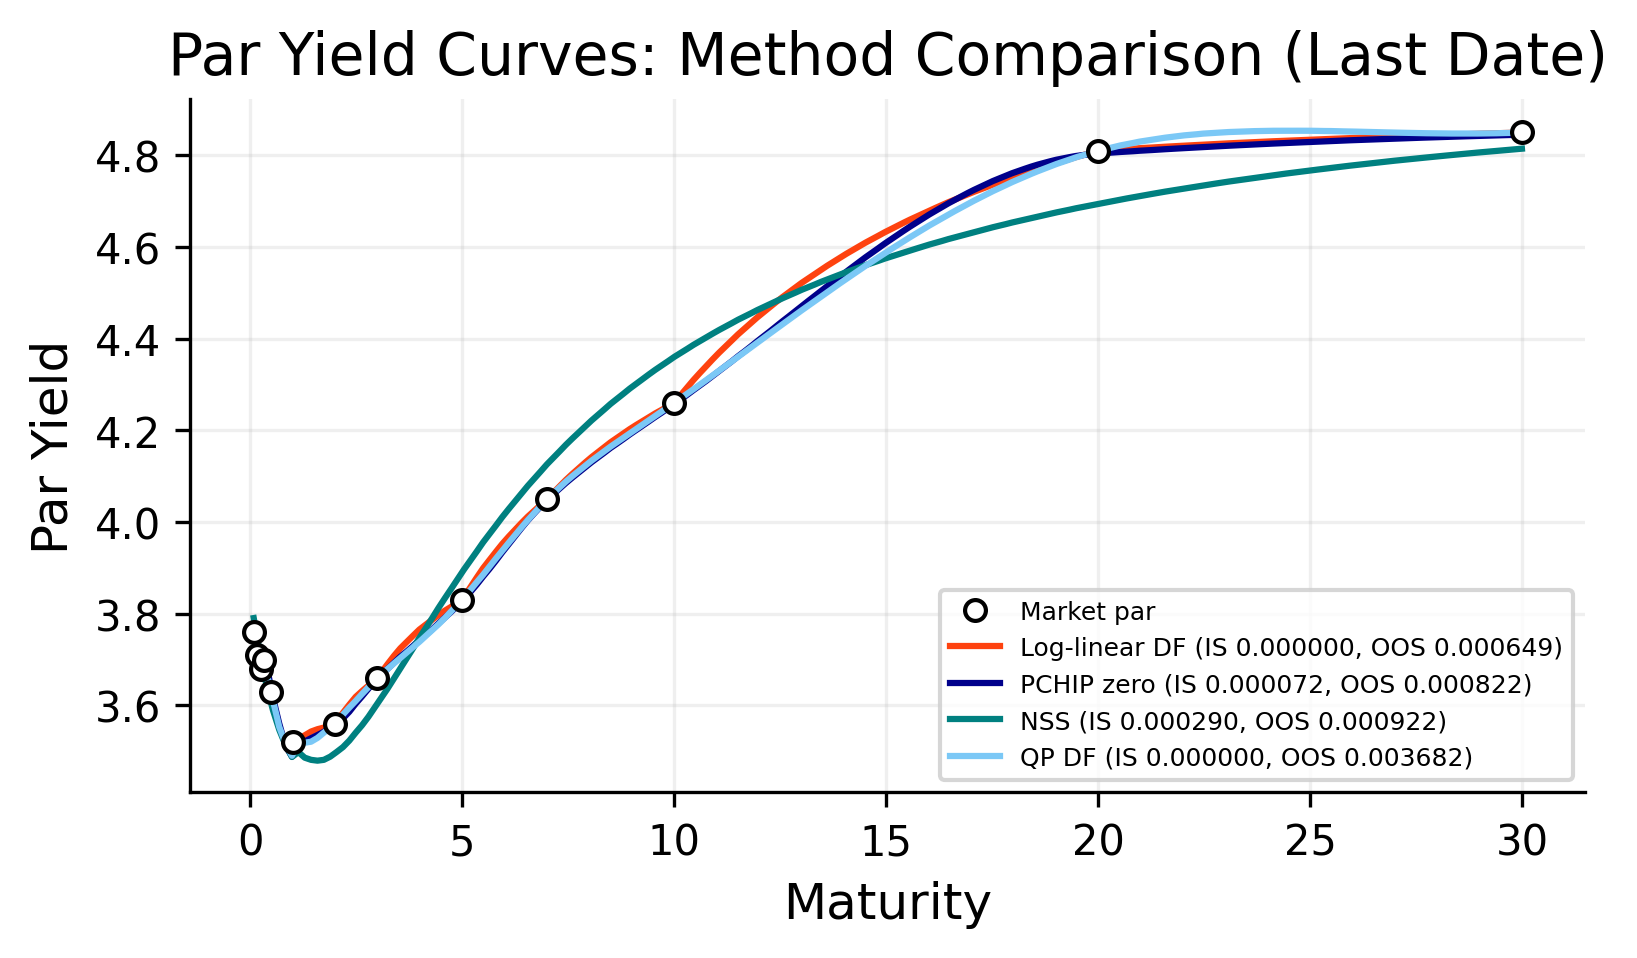

name          rmse  rmse_oos  n_obs  n_obs_oos  n_dates  \
method                                                                        
loglinear  Log-linear DF  9.937239e-14  0.000649    900        400      100   
pchip         PCHIP zero  7.233596e-05  0.000822    900        400      100   
nss                  NSS  2.895659e-04  0.000922    900        400      100   
qp                 QP DF  1.782548e-07  0.003682    900        400      100   

           n_dates_oos  
method                  
loglinear          100  
pchip              100  
nss                100  
qp                 100

In [13]:
def build_curves_for_date(date):
    pillars_full = bootstrap_pillars(date)
    if pillars_full is None:
        return None

    T_full = pillars_full["T"]
    par_full = pillars_full["par"]
    labels_full = pillars_full["labels"]


    holdouts = ["6M", "2Y", "7Y", "20Y"]
    holdout_idx = [labels_full.index(h) for h in holdouts if h in labels_full]


    holdout_idx = sorted(set([i for i in holdout_idx if 0 < i < len(labels_full) - 1]))
    min_train = 4
    if len(T_full) - len(holdout_idx) < min_train:
        holdout_idx = []


    if len(holdout_idx) > 0:
        mask_train = np.ones(len(T_full), dtype=bool)
        mask_train[holdout_idx] = False

        T_tr = T_full[mask_train]
        par_tr = par_full[mask_train]
        labels_tr = [labels_full[i] for i in range(len(labels_full)) if mask_train[i]]

        pillars = bootstrap_from_inputs(T_tr, par_tr, labels_tr, date=date)

        T_te = T_full[~mask_train]
        par_te = par_full[~mask_train]
        labels_te = [labels_full[i] for i in range(len(labels_full)) if not mask_train[i]]
    else:
        pillars = pillars_full
        T_te = np.array([], dtype=float)
        par_te = np.array([], dtype=float)
        labels_te = []

    pillars["T_test"] = T_te
    pillars["par_test"] = par_te
    pillars["labels_test"] = labels_te

    T_d = pillars["T"]
    par_d = pillars["par"]
    labels_d = pillars["labels"]
    dfs_d = pillars["dfs"]

    curves_d = {}
    errors = []

    try:
        curves_d["loglinear"] = loglinear_curve(T_d, dfs_d)
    except Exception as e:
        errors.append({"date": date, "method": "loglinear", "error": str(e)})

    try:
        curves_d["pchip"] = pchip_curve(T_d, dfs_d)
    except Exception as e:
        errors.append({"date": date, "method": "pchip", "error": str(e)})

    try:
        curves_d["nss"] = nss_curve(T_d, par_d)[0]
    except Exception as e:
        errors.append({"date": date, "method": "nss", "error": str(e)})

    try:
        curves_d["qp"] = qp_curve(labels_d, par_d)[0]
    except Exception as e:
        errors.append({"date": date, "method": "qp", "error": str(e)})

    return pillars, curves_d, errors


curve_order = ["loglinear", "pchip", "nss", "qp"]


rmse_sse = {k: 0.0 for k in curve_order}
rmse_count = {k: 0 for k in curve_order}
rmse_dates = {k: 0 for k in curve_order}
rmse_sse_oos = {k: 0.0 for k in curve_order}
rmse_count_oos = {k: 0 for k in curve_order}
rmse_dates_oos = {k: 0 for k in curve_order}

failed = []

for date in df_dec.index[-100:]:
    out = build_curves_for_date(date)
    if out is None:
        continue

    pillars_d, curves_d, errors = out
    failed.extend(errors)

    T_tr = pillars_d["T"]
    par_tr = pillars_d["par"]

    T_te = pillars_d["T_test"]
    par_te = pillars_d["par_test"]

    for k in curve_order:
        if k not in curves_d:
            continue
        try:
            c = curves_d[k]


            par_fit_tr = par_from_d(c["df_func"], T_tr)
            err_tr = par_fit_tr - par_tr
            rmse_sse[k] += float(np.sum(err_tr**2))
            rmse_count[k] += int(len(err_tr))
            rmse_dates[k] += 1

            if len(T_te) > 0:
                par_fit_te = par_from_d(c["df_func"], T_te)
                err_te = par_fit_te - par_te
                rmse_sse_oos[k] += float(np.sum(err_te**2))
                rmse_count_oos[k] += int(len(err_te))
                rmse_dates_oos[k] += 1

        except Exception as e:
            failed.append({"date": date, "method": k, "error": str(e)})

rmse_rows = []
for k in curve_order:
    if rmse_count[k] == 0:
        continue

    rmse_in = math.sqrt(rmse_sse[k] / rmse_count[k])
    rmse_out = (
        math.sqrt(rmse_sse_oos[k] / rmse_count_oos[k])
        if rmse_count_oos[k] > 0
        else float("nan")
    )


    name_val = curves[k]["name"] if ("curves" in globals() and k in curves) else k

    rmse_rows.append({"method": k, "name": name_val, "rmse": rmse_in, "rmse_oos": rmse_out,
            "n_obs": rmse_count[k], "n_obs_oos": rmse_count_oos[k], "n_dates": rmse_dates[k], "n_dates_oos": rmse_dates_oos[k],})

rmse_df = pd.DataFrame(rmse_rows).set_index("method")

if len(failed) > 0:
    print(f"Failed date-method pairs: {len(failed)}")
    display(pd.DataFrame(failed).head())


plot_grid = np.linspace(max(1 / 12, T.min()), T.max(), 200)

plt.figure()
plt.plot(T, par * 100.0, "o", markersize=5, markeredgecolor="black", markerfacecolor="white", label="Market par", zorder=5)

for k in curve_order:
    c = curves[k]
    par_grid = par_from_d(c["df_func"], plot_grid)

    rmse_in = rmse_df.loc[k, "rmse"] if k in rmse_df.index else float("nan")
    rmse_out = rmse_df.loc[k, "rmse_oos"] if k in rmse_df.index else float("nan")

    plt.plot(plot_grid, par_grid * 100.0, label=f"{c['name']} (IS {rmse_in:.6f}, OOS {rmse_out:.6f})")

plt.title("Par Yield Curves: Method Comparison (Last Date)")
plt.xlabel("Maturity")
plt.ylabel("Par Yield")
plt.legend()
plt.show()

rmse_df


## 11) Synthetic Bond Issuance (Issued at Par)

because we don't have official data for this part, We simulate a monthly issuance program using par yields to create a rolling book of bonds so we can analyze our models and implement the next topics.
Each month, we pretend the Treasury issues new par bonds at a few maturities (like 2Y, 5Y, 10Y, 30Y).
The coupon of each new bond is set to that month’s par yield at that maturity (from the dataset).
Because coupon = par yield at issuance, each new bond starts at price approximately equal to 1 (par).

### Details of the bond
- for each month $t_0$ we create a new bond with maturity $T$ and frequency $f$
- $f$ = semiannual
- $T = {2Y, 5Y, 10Y, 30Y}$
- coupon: $c_d(T)=y_d(T)$ (the market par yield at that date and maturity)
- notional $N=1$

Basically we buy bonds with 4 different maturities every month and keep it and get interest every month until maturity of those bonds. so we have 4 books for 4 different bonds (maturities). and our portfolio is based on these four books.

So each month the outgoing cashflow is buying the bonds and ingoing is all the interest and maybe principal of all the bonds that we have bought.



In [15]:
issue_maturities = [2, 5, 10, 30]
issue_labels = {2: "2Y", 5: "5Y", 10: "10Y", 30: "30Y"}


month_end_curve = df_dec[tenor_cols].resample("ME").last()
issue_dates = month_end_curve.index


def yearfrac(t0, t1):
    return (t1 - t0).days / 365


def bond_cashflows(c, T, f=2):
    times = np.arange(1 / f, T + 1e-9, 1 / f)
    cfs = np.full_like(times, c / f)
    cfs[-1] += 1.0
    return times, cfs


def price_bond(df_func, times, cfs, delta):
    mask = times > delta + 1e-12
    if not np.any(mask):
        return 0.0
    t_rem = times[mask] - delta
    cf_rem = cfs[mask]
    return float(np.sum(cf_rem * df_func(t_rem)))



issuance_book = {T: [] for T in issue_maturities}
for d in issue_dates:
    row = month_end_curve.loc[d]
    for T in issue_maturities:
        label = issue_labels[T]
        c = float(row.get(label, np.nan))
        if not np.isfinite(c):
            continue
        times, cfs = bond_cashflows(c, T, f)
        issuance_book[T].append({
            "issue_date": d,
            "coupon": c,
            "times": times,
            "cfs": cfs,
        })

issuance_summary = pd.DataFrame({
    "n_bonds": {T: len(issuance_book[T]) for T in issue_maturities},
    "first_issue": {T: issuance_book[T][0]["issue_date"] if len(issuance_book[T]) > 0 else pd.NaT for T in issue_maturities},
    "last_issue": {T: issuance_book[T][-1]["issue_date"] if len(issuance_book[T]) > 0 else pd.NaT for T in issue_maturities},
})

print("Issuance summary:")
display(issuance_summary)

Issuance summary:


n_bonds first_issue last_issue
2       433  1990-01-31 2026-01-31
5       433  1990-01-31 2026-01-31
10      433  1990-01-31 2026-01-31
30      386  1990-01-31 2026-01-31

## 12) Pricing an Issued Bond at a Later Date

If issue date be $t_0$ and valuation date be $t$.
Elapsed time is the amount of time that has been passed from the bond issued at $t_0$ in valuation time $t$:
$\Delta=\tau(t_0,t)$

reminder: $\tau(t_0,t_1)=\dfrac{\text{days}(t_0,t_1)}{365}$

Original scheduled payment times from issue are $t_i=i/f$.
we only price the bonds that $t_i>\Delta$ because these are the cashflows that have accured up until time $t$ and the remaining time to payment from valuation date for each cashflow is:
$\tau_i(t)=t_i-\Delta$

Price using the curve at valuation date $t$:
$P_t=\sum_{i:t_i>\Delta} CF_i\,D_t(\tau_i(t))$

For a book of issues $\mathcal{B}_t$ with weights $w_b$ (we don't have weights here):
$PV_t=\sum_{b\in \mathcal{B}_t} w_b\,P_t(b)$

In [ ]:
def book_pv_cutoff(valuation_date, df_func, cutoff_date):
    total = 0.0
    buckets = {}
    for T in issue_maturities:
        pv = 0.0
        for bond in issuance_book[T]:
            if bond["issue_date"] > cutoff_date:
                break
            delta = yearfrac(bond["issue_date"], valuation_date)
            if delta >= bond["times"][-1] - 1e-12:
                continue
            pv += price_bond(df_func, bond["times"], bond["cfs"], delta)
        buckets[T] = pv
        total += pv
    return total, buckets


def shifted_df_func(df_func, shift_func):
    def _f(t):
        t = np.array(t, dtype=float)
        return df_func(t) * np.exp(-shift_func(t) * t)
    return _f


def key_bump_func(key, bump_bp=1.0):
    values = np.zeros(len(issue_maturities), dtype=float)
    key_idx = issue_maturities.index(key)
    values[key_idx] = bump_bp / 10000.0

    def shift(t):
        t = np.array(t, dtype=float)
        return np.interp(t, issue_maturities, values, left=0.0, right=0.0)

    return shift


def curve_date_for(d):
    if d in df_dec.index:
        return d
    idx = df_dec.index.searchsorted(d, side="right") - 1
    if idx < 0:
        return None
    return df_dec.index[idx]


def book_pv(date, df_func):
    total = 0.0
    buckets = {}
    for T in issue_maturities:
        pv = 0.0
        for bond in issuance_book[T]:
            if bond["issue_date"] > date:
                break
            delta = yearfrac(bond["issue_date"], date)
            if delta >= bond["times"][-1] - 1e-12:
                continue
            pv += price_bond(df_func, bond["times"], bond["cfs"], delta)
        buckets[T] = pv
        total += pv
    return total, buckets


curves_cache = {}


def get_curves_for(date):
    if date in curves_cache:
        return curves_cache[date]
    out = build_curves_for_date(date)
    if out is None:
        curves_cache[date] = None
        return None
    _, curves_d, _ = out
    curves_cache[date] = curves_d
    return curves_d


In [ ]:


metrics_rows = []

for date in issue_dates:
    curve_date = curve_date_for(date)
    if curve_date is None:
        continue

    curves_d = get_curves_for(curve_date)
    if curves_d is None:
        continue

    for method, curve in curves_d.items():
        df0 = curve["df_func"]
        pv0, _ = book_pv_cutoff(date, df0, cutoff_date=date)
        metrics_rows.append({"date": date, "method": method, "pv": pv0})

metrics_df = pd.DataFrame(metrics_rows).set_index(["date", "method"]).sort_index()



Total PV by method (last day):


method       loglinear         nss       pchip          qp
date                                                      
1990-01-31    3.999816    3.999349    4.001830    4.004113
1990-02-28    8.007579    8.006109    8.012242    8.016726
1990-03-31   12.003136   12.000914   12.004738   12.017158
1990-04-30   15.838917   15.837035   15.838465   15.859415
1990-05-31   20.350563   20.347476   20.353669   20.375817
...                ...         ...         ...         ...
2025-09-30  484.048043  485.413949  485.289343  486.914561
2025-10-31  486.071558  486.930897  487.319872  488.950688
2025-11-30  487.714383  489.811404  489.252157  491.052541
2025-12-31  482.340428  484.351486  483.847004  485.803466
2026-01-31  481.069937  482.642714  482.367938  484.081282

[433 rows x 4 columns]

Bucket PV (last date)


method     loglinear         nss       pchip          qp
maturity                                                
2          24.258462   24.266940   24.265987   24.267663
5          60.518216   60.565183   60.549000   60.551390
10        115.921913  116.063170  116.097292  116.098827
30        280.371346  281.747421  281.455658  283.163402

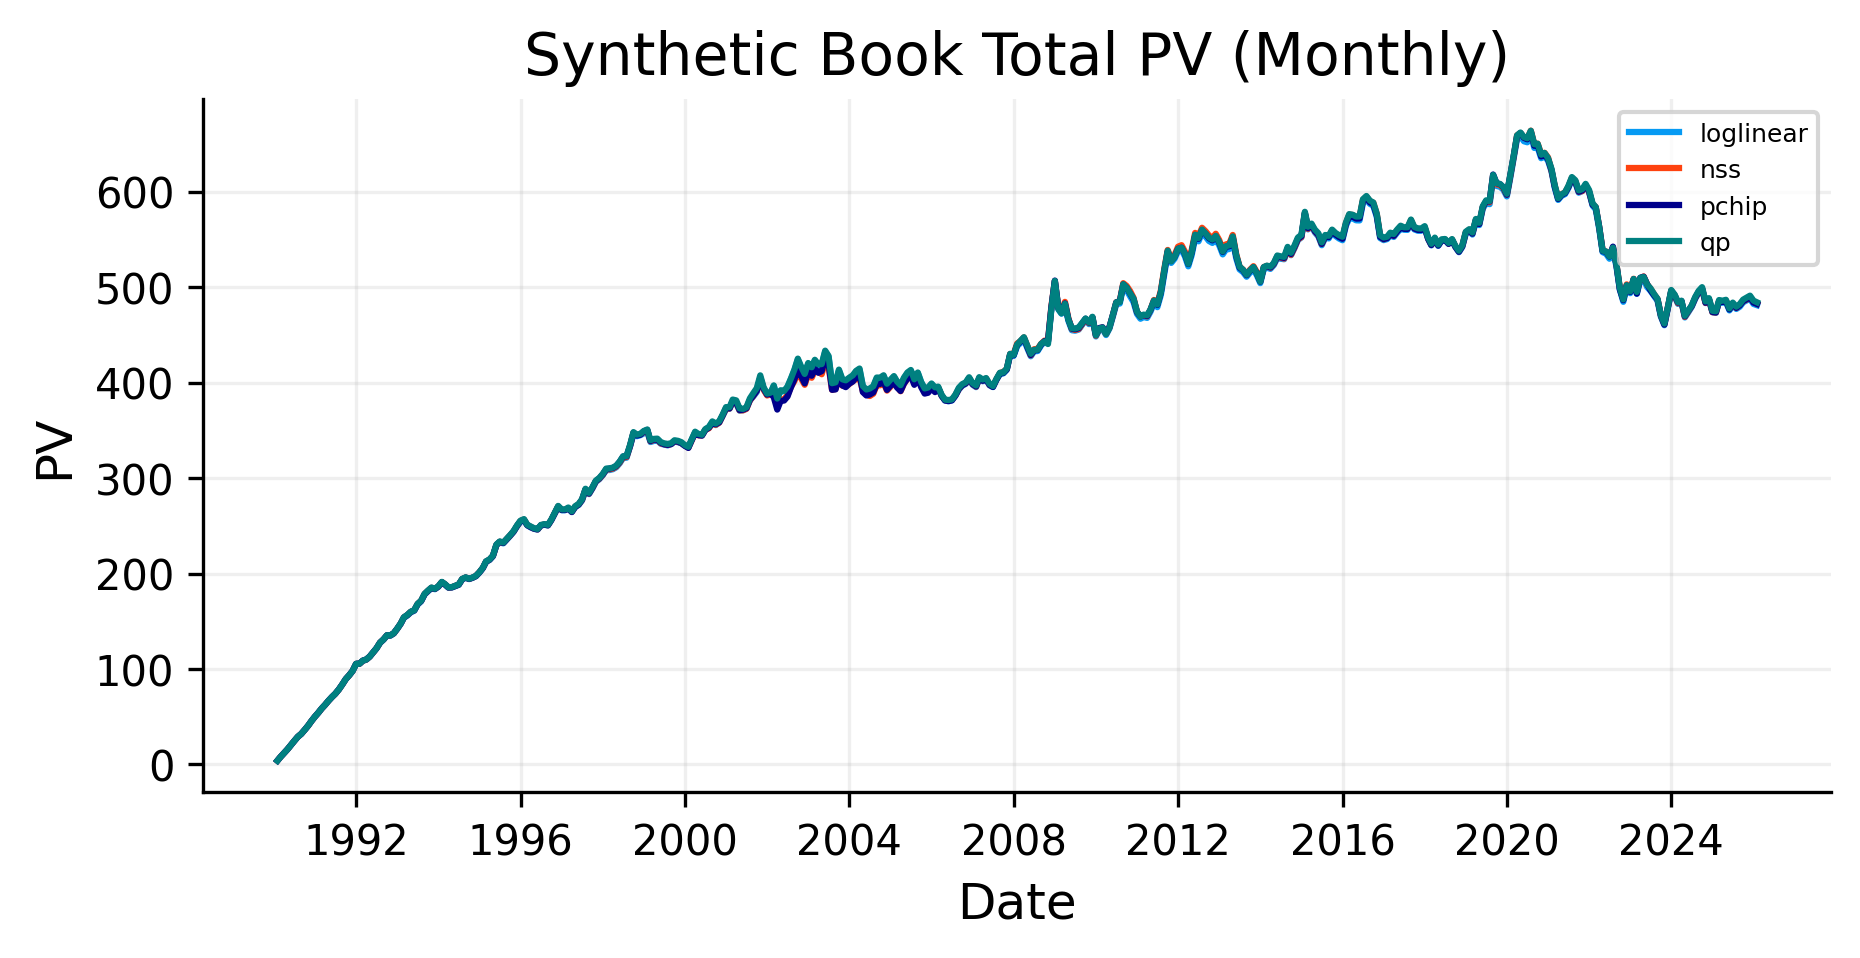

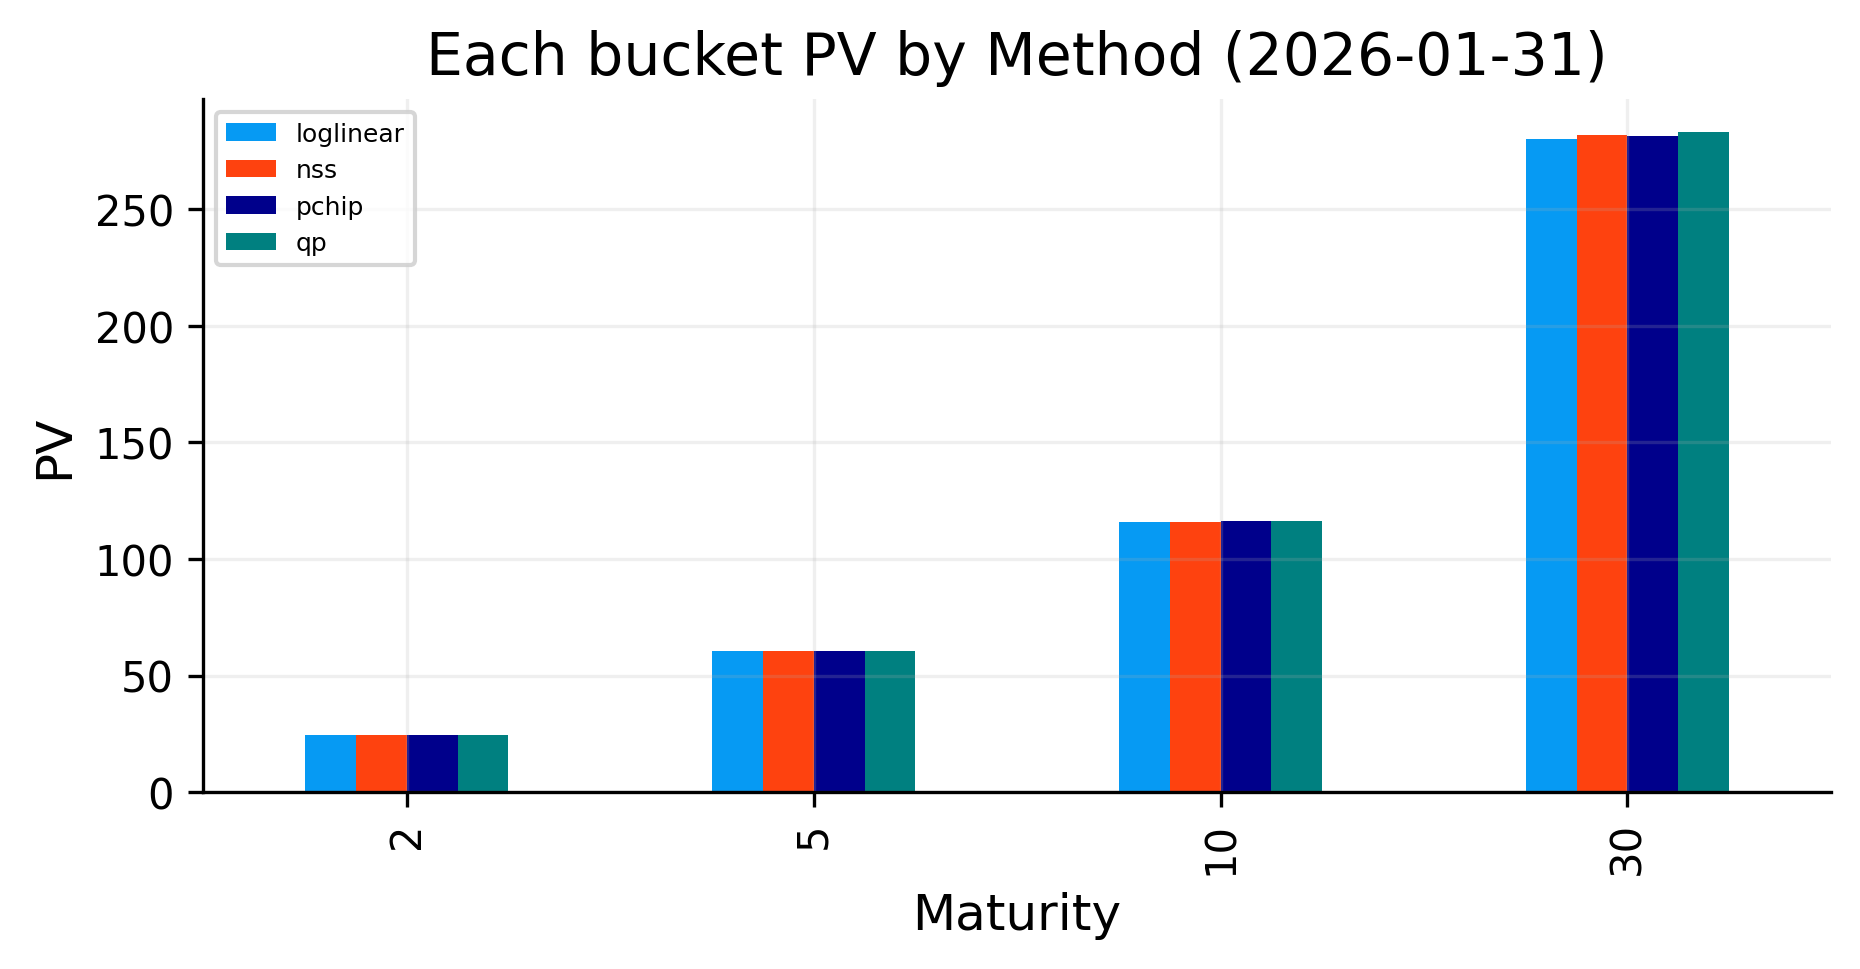

In [ ]:
methods = ["loglinear", "pchip", "nss", "qp"]

pv_total = (
    metrics_df.reset_index()
    .pivot(index="date", columns="method", values="pv")
    .sort_index()
)

pv_rows = []
failed = []

for date in issue_dates:
    curve_date = curve_date_for(date)
    if curve_date is None:
        continue

    curves_d = get_curves_for(curve_date)
    if curves_d is None:
        continue

    for method, curve in curves_d.items():
        df_func = curve["df_func"]
        _, buckets = book_pv_cutoff(date, df_func, cutoff_date=date)
        for T in issue_maturities:
            pv_rows.append({"date": date, "method": method, "maturity": T, "pv": buckets.get(T, 0.0)})

pv_df = pd.DataFrame(pv_rows)
pv_buckets = pv_df.pivot_table(index="date", columns=["method", "maturity"], values="pv").sort_index()

print("Total PV by method (last day):")
display(pv_total)

print("Bucket PV (last date)")
last_date = pv_df["date"].max()
last_bucket = pv_df[pv_df["date"] == last_date].pivot_table(index="maturity", columns="method", values="pv")
display(last_bucket)

plt.figure()
for method in pv_total.columns:
    plt.plot(pv_total.index, pv_total[method], label=method)
plt.title("Synthetic Book Total PV (Monthly)")
plt.xlabel("Date")
plt.ylabel("PV")
plt.legend()
plt.show()

plt.figure()
last_bucket.plot(kind="bar", ax=plt.gca())
plt.title(f"Each bucket PV by Method ({last_date.date()})")
plt.xlabel("Maturity")
plt.ylabel("PV")
plt.legend()
plt.show()


## 15) Risk and sensitivity measures of bonds

### 15.1 PV01/ DV01
for measuring the risk of these bonds, we can use the sensitivity of the **price of bond** to a little change in interest rates.

PV01 is the change in PV of the bond when the curve bumps by 1 basis point.
DV01 is the value in dollar unit of that which is kind of the same concept

$\dfrac{dP}{dy}=-\sum_{i=1}^n CF_i,t_i,D(t_i)$

For approximation, we take $\Delta=0.0001$ (1 basis point move), Parallel-shifted discount factor will be:

$D^{up}(t)=\exp(-(z(t)+\Delta)t)$

PV01 will be:

$PV01=P_0-P_{up}$






### 15.2 Convexity

convexity is basically the sensitivity of **PV01** to a little change in curve. and it's the second order partial derivative of price from yield

$\dfrac{d^2P}{dy^2}=\sum_{i=1}^n CF_i,t_i^2,D(t_i)$

Using central differences with shift size $\Delta$:

$Conv=\dfrac{P_{down}+P_{up}-2P_0}{P_0\Delta^2}$
where
$P_{up}$ uses $+\Delta$ and $P_{down}$ uses $-\Delta$.

---

### 15.3 Key Rate Duration (KRD)

the problem is that we assume that yields parallel shift. but they can twist. if 2Y goes up it doesn't mean 10Y will go up exactly the same amount. (Duration is a normalized version of PV01)

So we choose key tenors $k_1<k_2<\dots<k_m$. as our key rates and measure the sensitivity of them while the other tenors in the curve stay the same.

Tent / triangular bump shape

Define localized bump functions $b_j(t)$ such that $b_j(K_j)=1$ and $b_j(t)=0$ outside a neighborhood.

A triangular bump with edges $L_j<R_j$:

$b_j(t)=0$ for $t\le L_j$  

$b_j(t)=\dfrac{t-L_j}{K_j-L_j}$ for $L_j<t\le K_j$  

$b_j(t)=\dfrac{R_j-t}{R_j-K_j}$ for $K_j<t\le R_j$  

$b_j(t)=0$ for $t>R_j$


Bumped zero curve (only around key $k_j$):

$z^{(j)}(t)=z(t)+\Delta b_j(t)$

So bumped discount factors:


$D^{(j)}(t)=\exp(-(z(t)+\Delta b_j(t))t)$

Price under the key bump:

$P^{(j)}(\Delta)=\sum_{i=1}^n CF_i,D(t_i),e^{-\Delta,b_j(t_i),t_i}$

KRD definition (finite-difference)

$KRD_j=\dfrac{P_0-P^{(j)}}{P_0\Delta}$


---


Risk metrics (last date)


pv01   convexity
date       method                         
2026-01-31 loglinear  0.357311  107.577415
           nss        0.359623  108.064523
           pchip      0.358863  107.715321
           qp         0.362471  108.928968

KRD for last date


krd
date       method key             
2026-01-31 qp     2     199.706778
                  5     584.865209
                  10   1608.487463
                  30   1104.026025

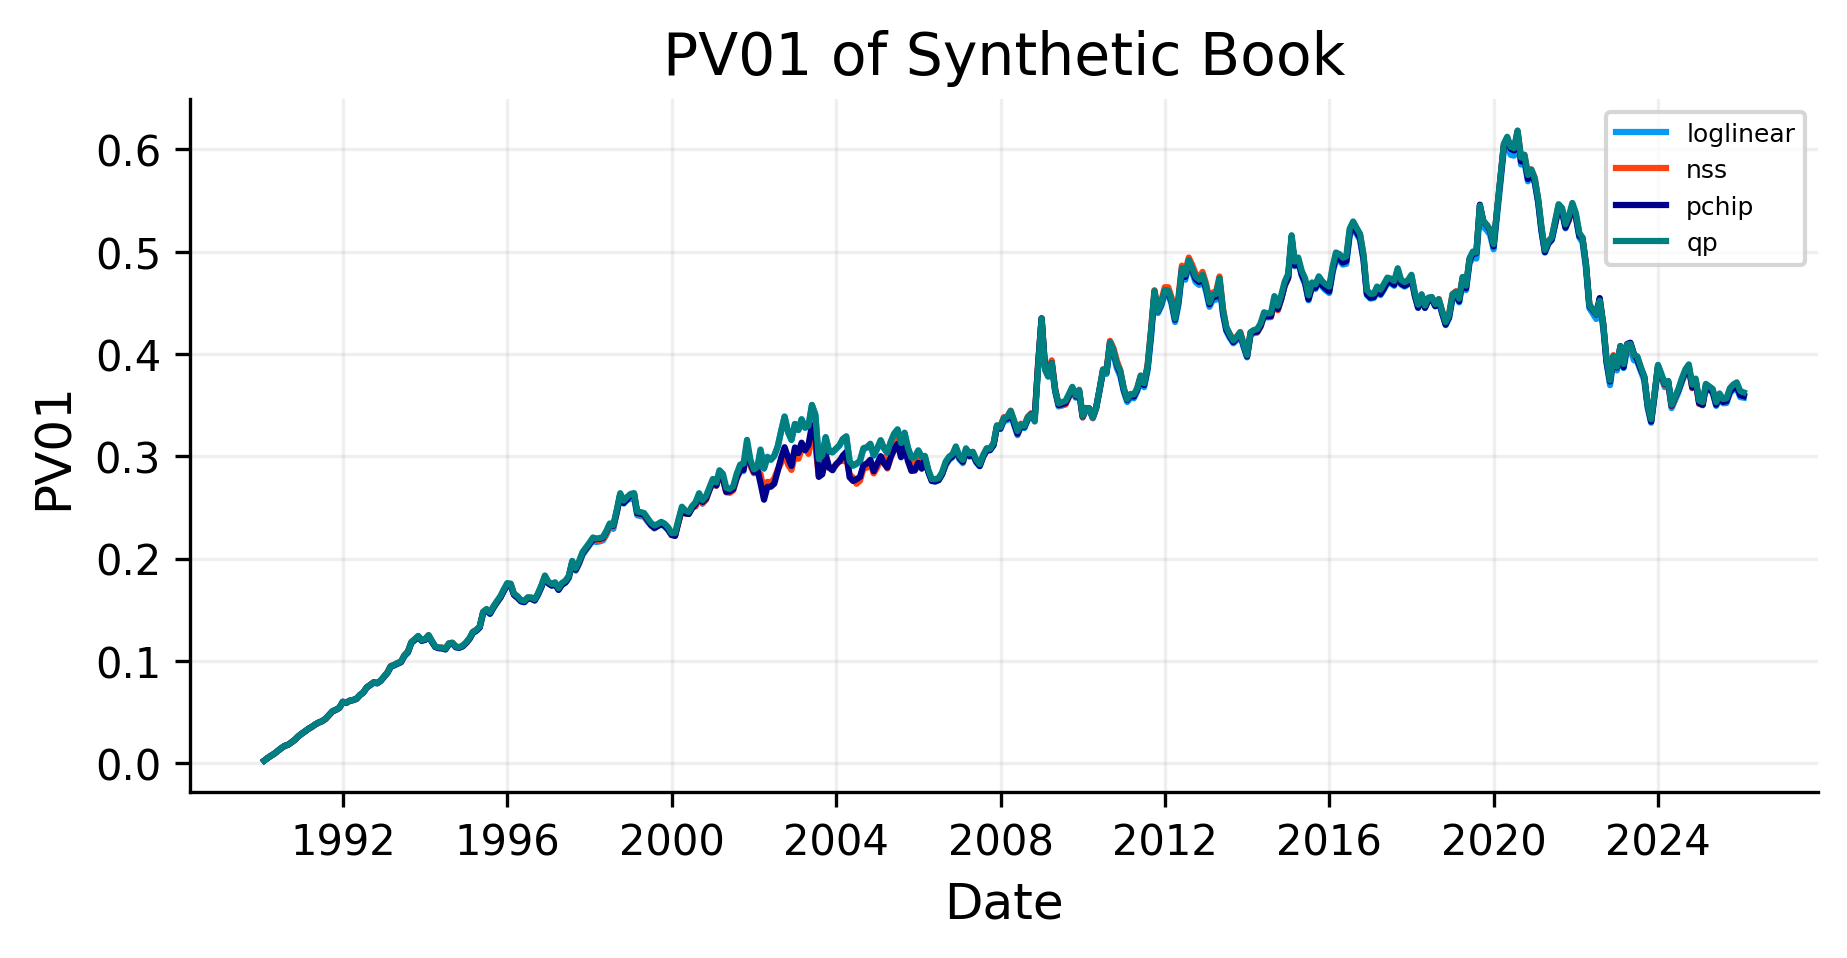

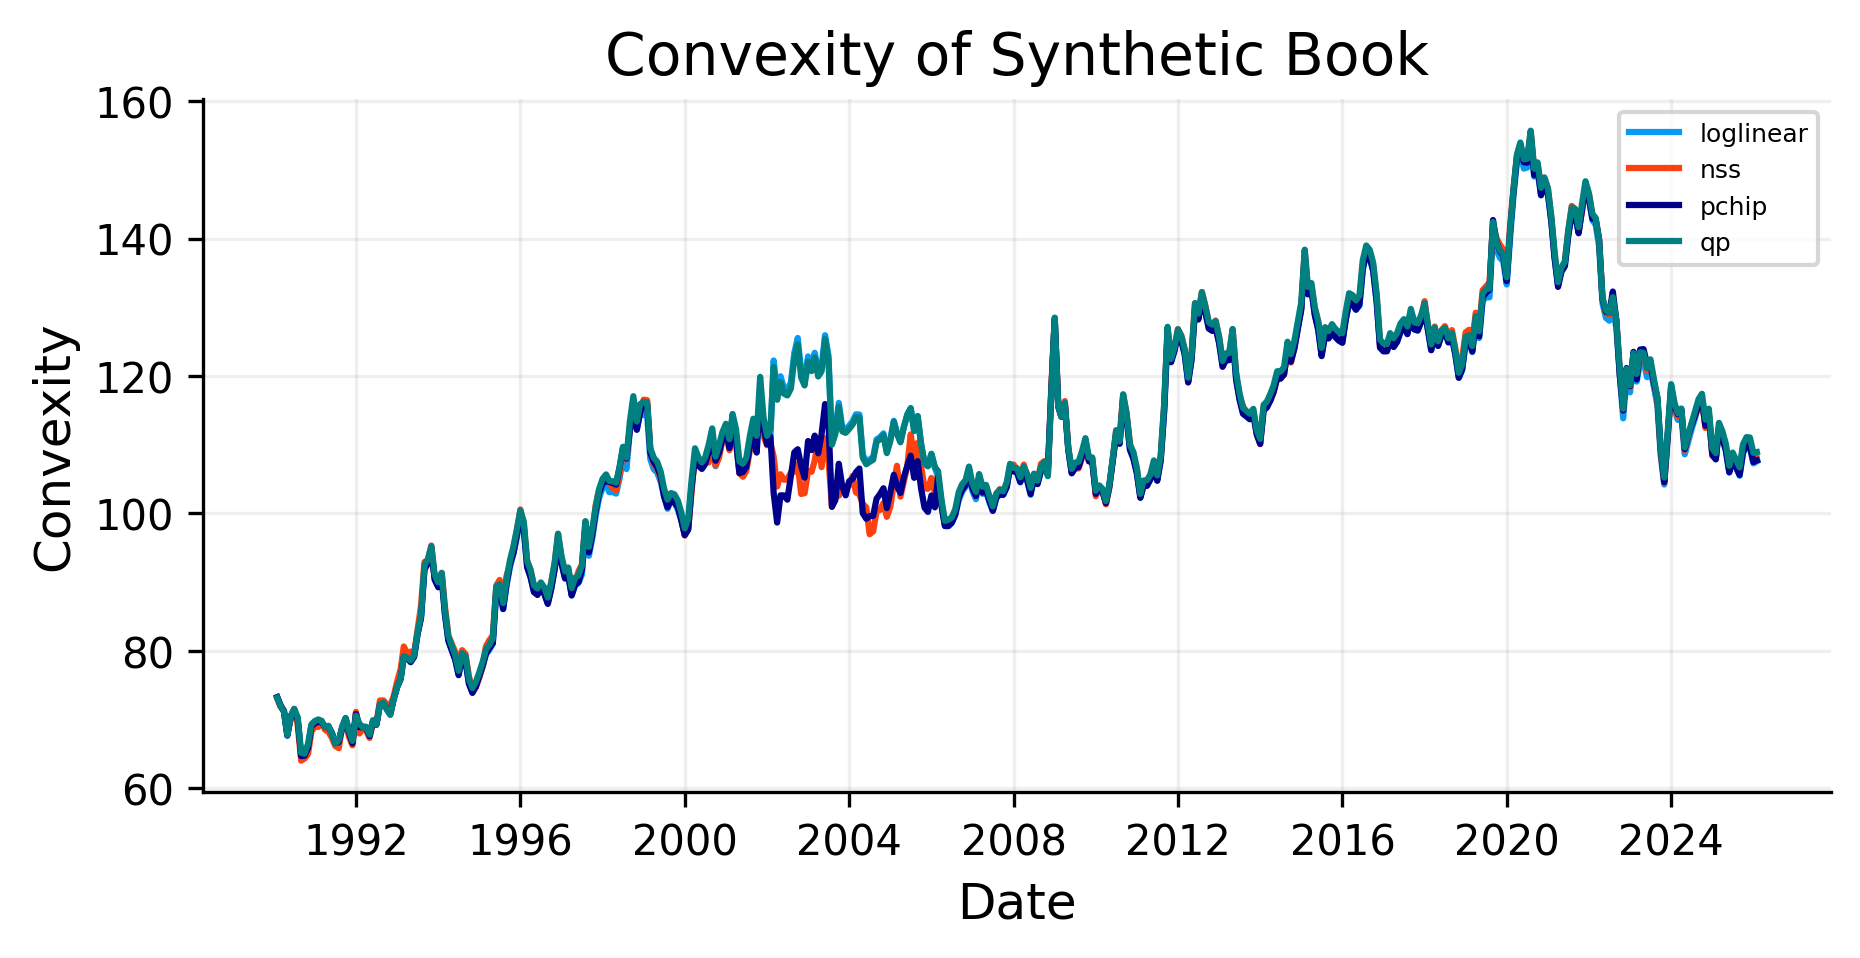

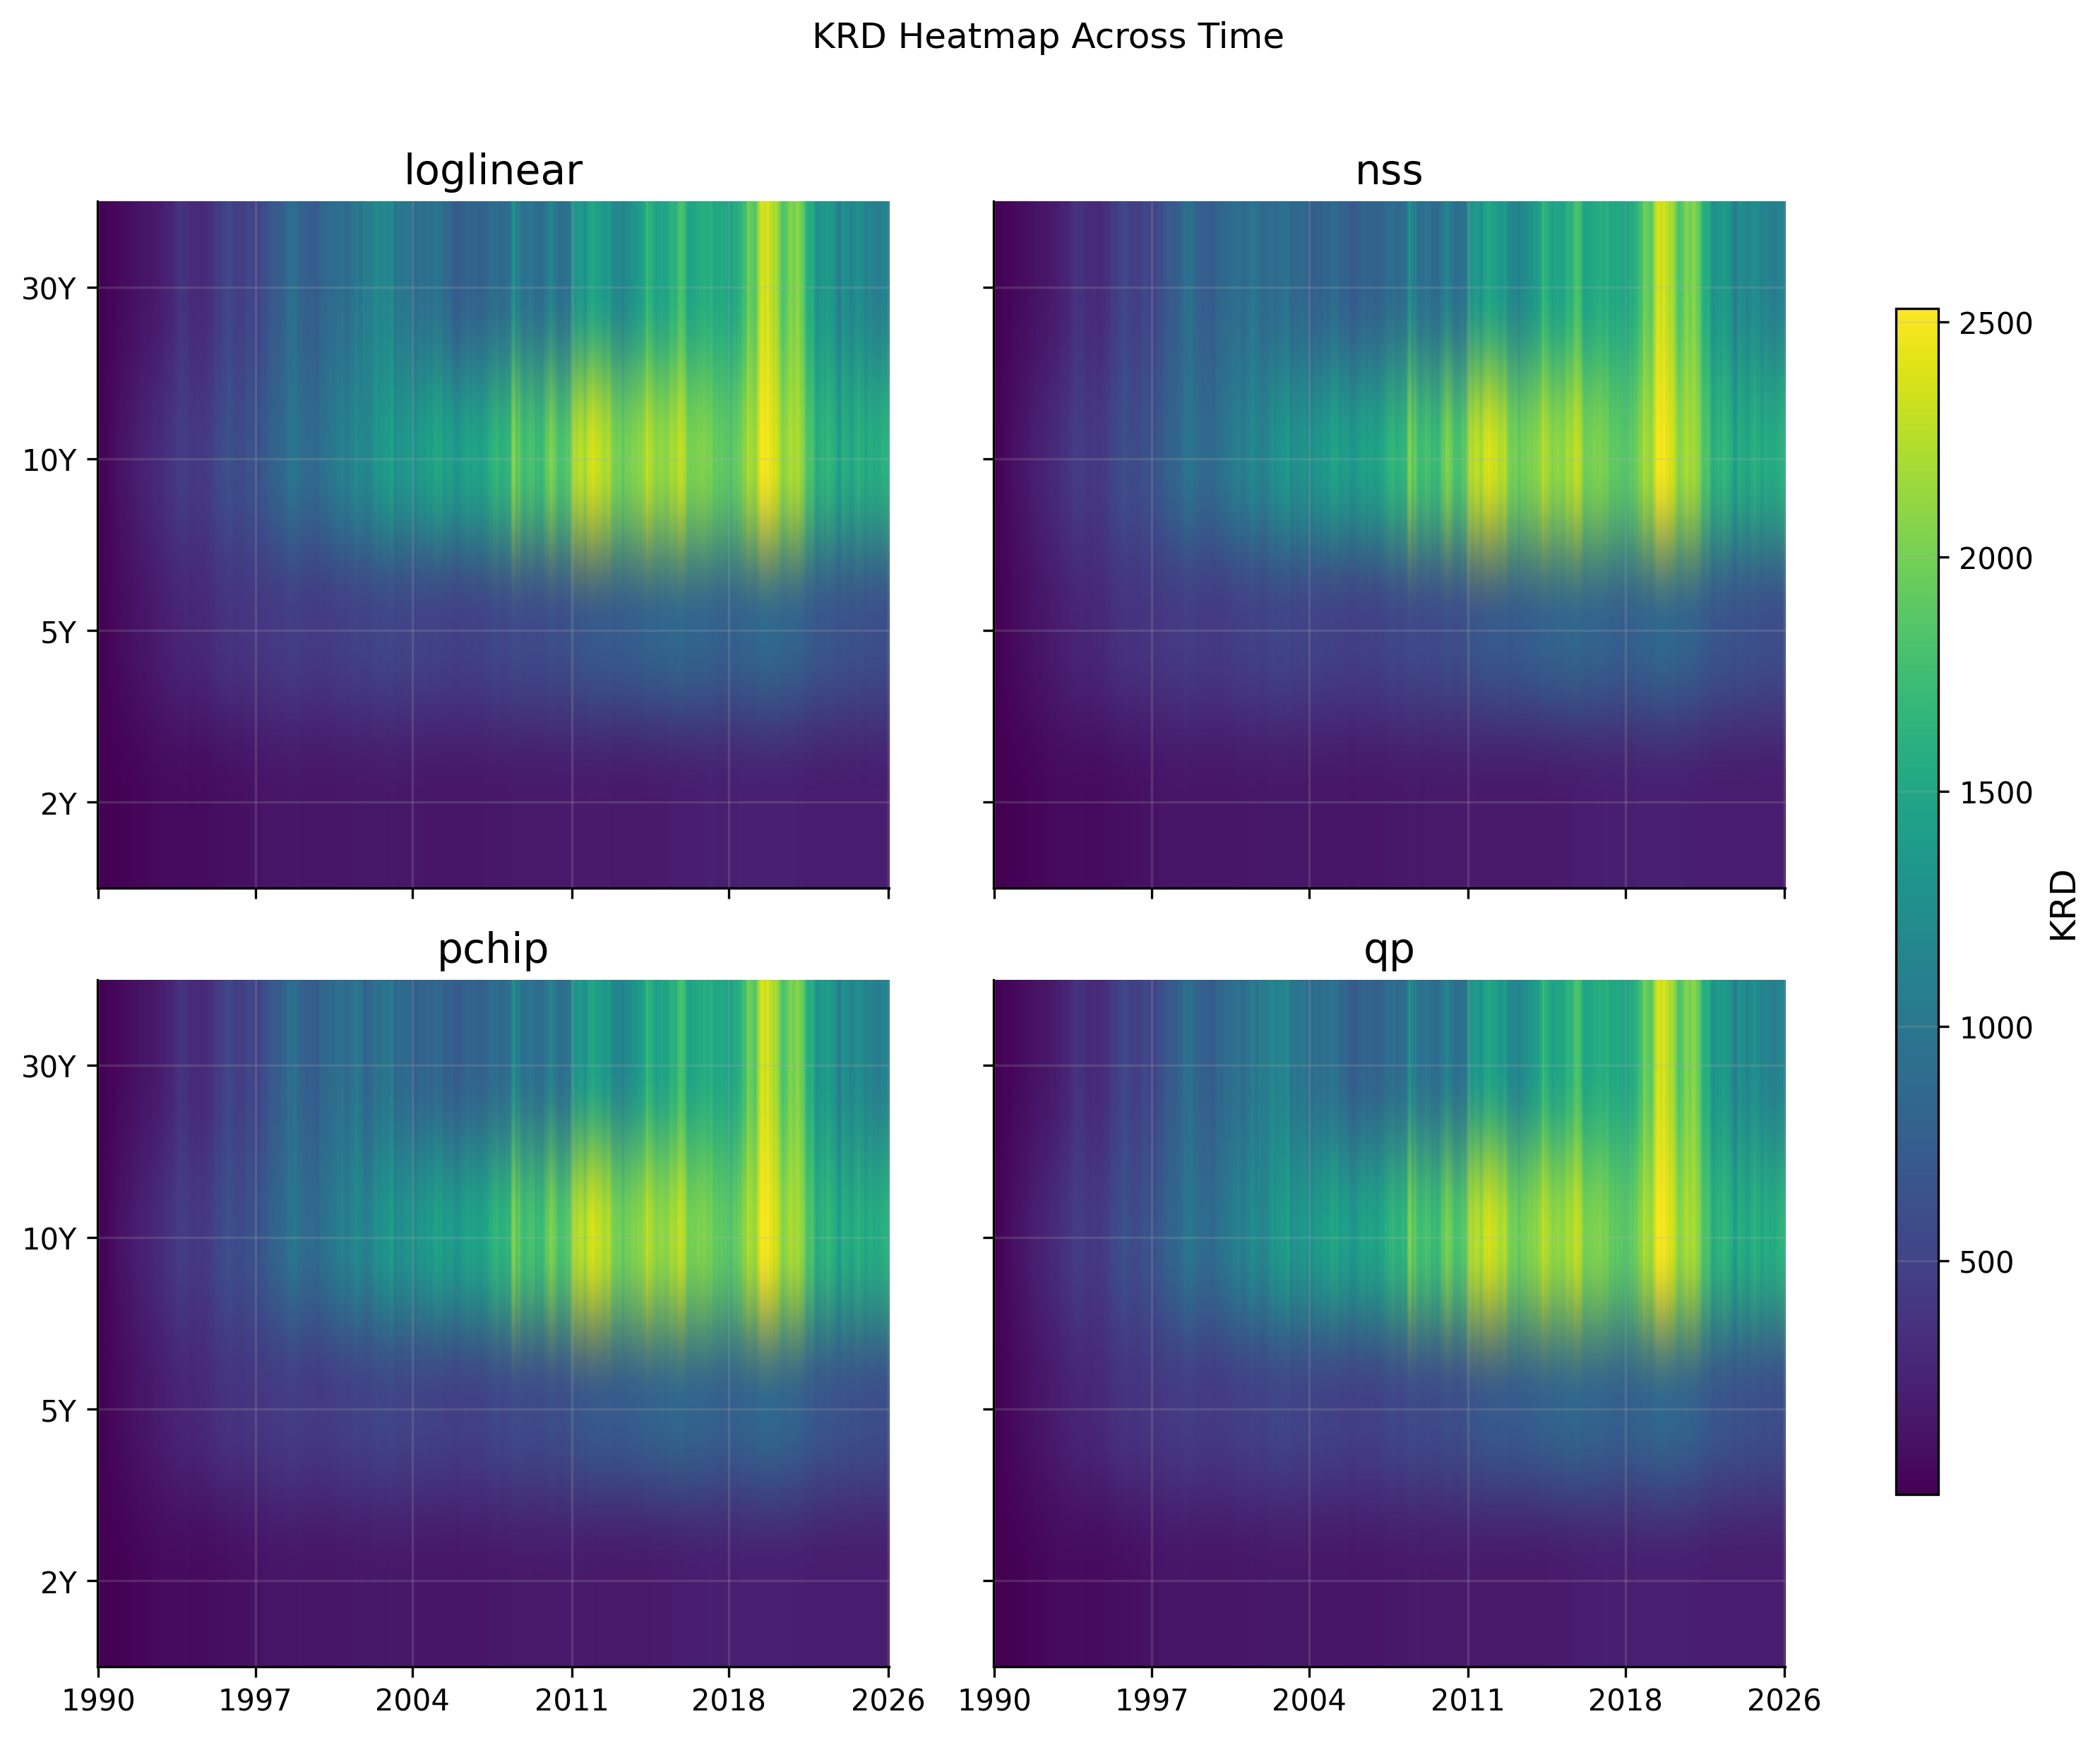

In [ ]:
risk_rows = []
krd_rows = []

for (date, method), row in metrics_df.iterrows():
    curve_date = curve_date_for(date)
    if curve_date is None:
        continue
    curves_d = get_curves_for(curve_date)
    if curves_d is None:
        continue

    df_func = curves_d[method]["df_func"]
    pv0 = row["pv"]

    shift_up = shifted_df_func(df_func, lambda t: np.full_like(np.array(t, dtype=float), 0.0001))
    shift_dn = shifted_df_func(df_func, lambda t: np.full_like(np.array(t, dtype=float), -0.0001))
    pv_up, _ = book_pv(date, shift_up)
    pv_dn, _ = book_pv(date, shift_dn)

    pv01 = (pv_dn - pv_up) / 2.0
    convexity = (pv_up + pv_dn - 2.0 * pv0) / (pv0 * (0.0001 ** 2)) if pv0 != 0 else np.nan

    risk_rows.append({
        "date": date,
        "method": method,
        "pv01": pv01,
        "convexity": convexity,
    })

    for k in issue_maturities:
        bump = key_bump_func(k, bump_bp=1.0)
        df_bump = shifted_df_func(df_func, bump)
        pv_bump, _ = book_pv(date, df_bump)
        krd = (pv0 - pv_bump) / 0.0001
        krd_rows.append({
            "date": date,
            "method": method,
            "key": k,
            "krd": krd,
        })

risk_df = pd.DataFrame(risk_rows).set_index(["date", "method"]).sort_index()
metrics_df = metrics_df.join(risk_df)

krd_df = pd.DataFrame(krd_rows).set_index(["date", "method", "key"]).sort_index()

print("Risk metrics (last date)")
display(metrics_df[["pv01", "convexity"]].tail(4))

print("KRD for last date")
display(krd_df.tail(4))

plt.figure()
for method in sorted(metrics_df.index.get_level_values("method").unique()):
    data = metrics_df.xs(method, level="method")
    plt.plot(data.index, data["pv01"], label=method)
plt.title("PV01 of Synthetic Book")
plt.xlabel("Date")
plt.ylabel("PV01")
plt.legend()
plt.show()


plt.figure()
for method in sorted(metrics_df.index.get_level_values("method").unique()):
    data = metrics_df.xs(method, level="method")
    plt.plot(data.index, data["convexity"], label=method)
plt.title("Convexity of Synthetic Book")
plt.xlabel("Date")
plt.ylabel("Convexity")
plt.legend()
plt.show()



methods = sorted(metrics_df.index.get_level_values("method").unique())
krd_panel = krd_df.reset_index()

fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)
axes = axes.flatten()
fig.subplots_adjust(right=0.88)

for ax, method in zip(axes, methods, strict=True):
    data = krd_panel[krd_panel["method"] == method]
    pivot = data.pivot(index="date", columns="key", values="krd").reindex(columns=issue_maturities)
    im = ax.imshow(pivot.values.T, aspect="auto", origin="lower")
    ax.set_title(method)
    ax.set_yticks(range(len(issue_maturities)))
    ax.set_yticklabels([f"{k}Y" for k in issue_maturities])

    tick_idx = np.linspace(0, len(pivot.index) - 1, 6).astype(int)
    ax.set_xticks(tick_idx)
    ax.set_xticklabels([pivot.index[i].strftime("%Y") for i in tick_idx])

cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cax, label="KRD")
fig.suptitle("KRD Heatmap Across Time", y=1.02)
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()


# Implementing the whole project on Japan data using quantfinlab

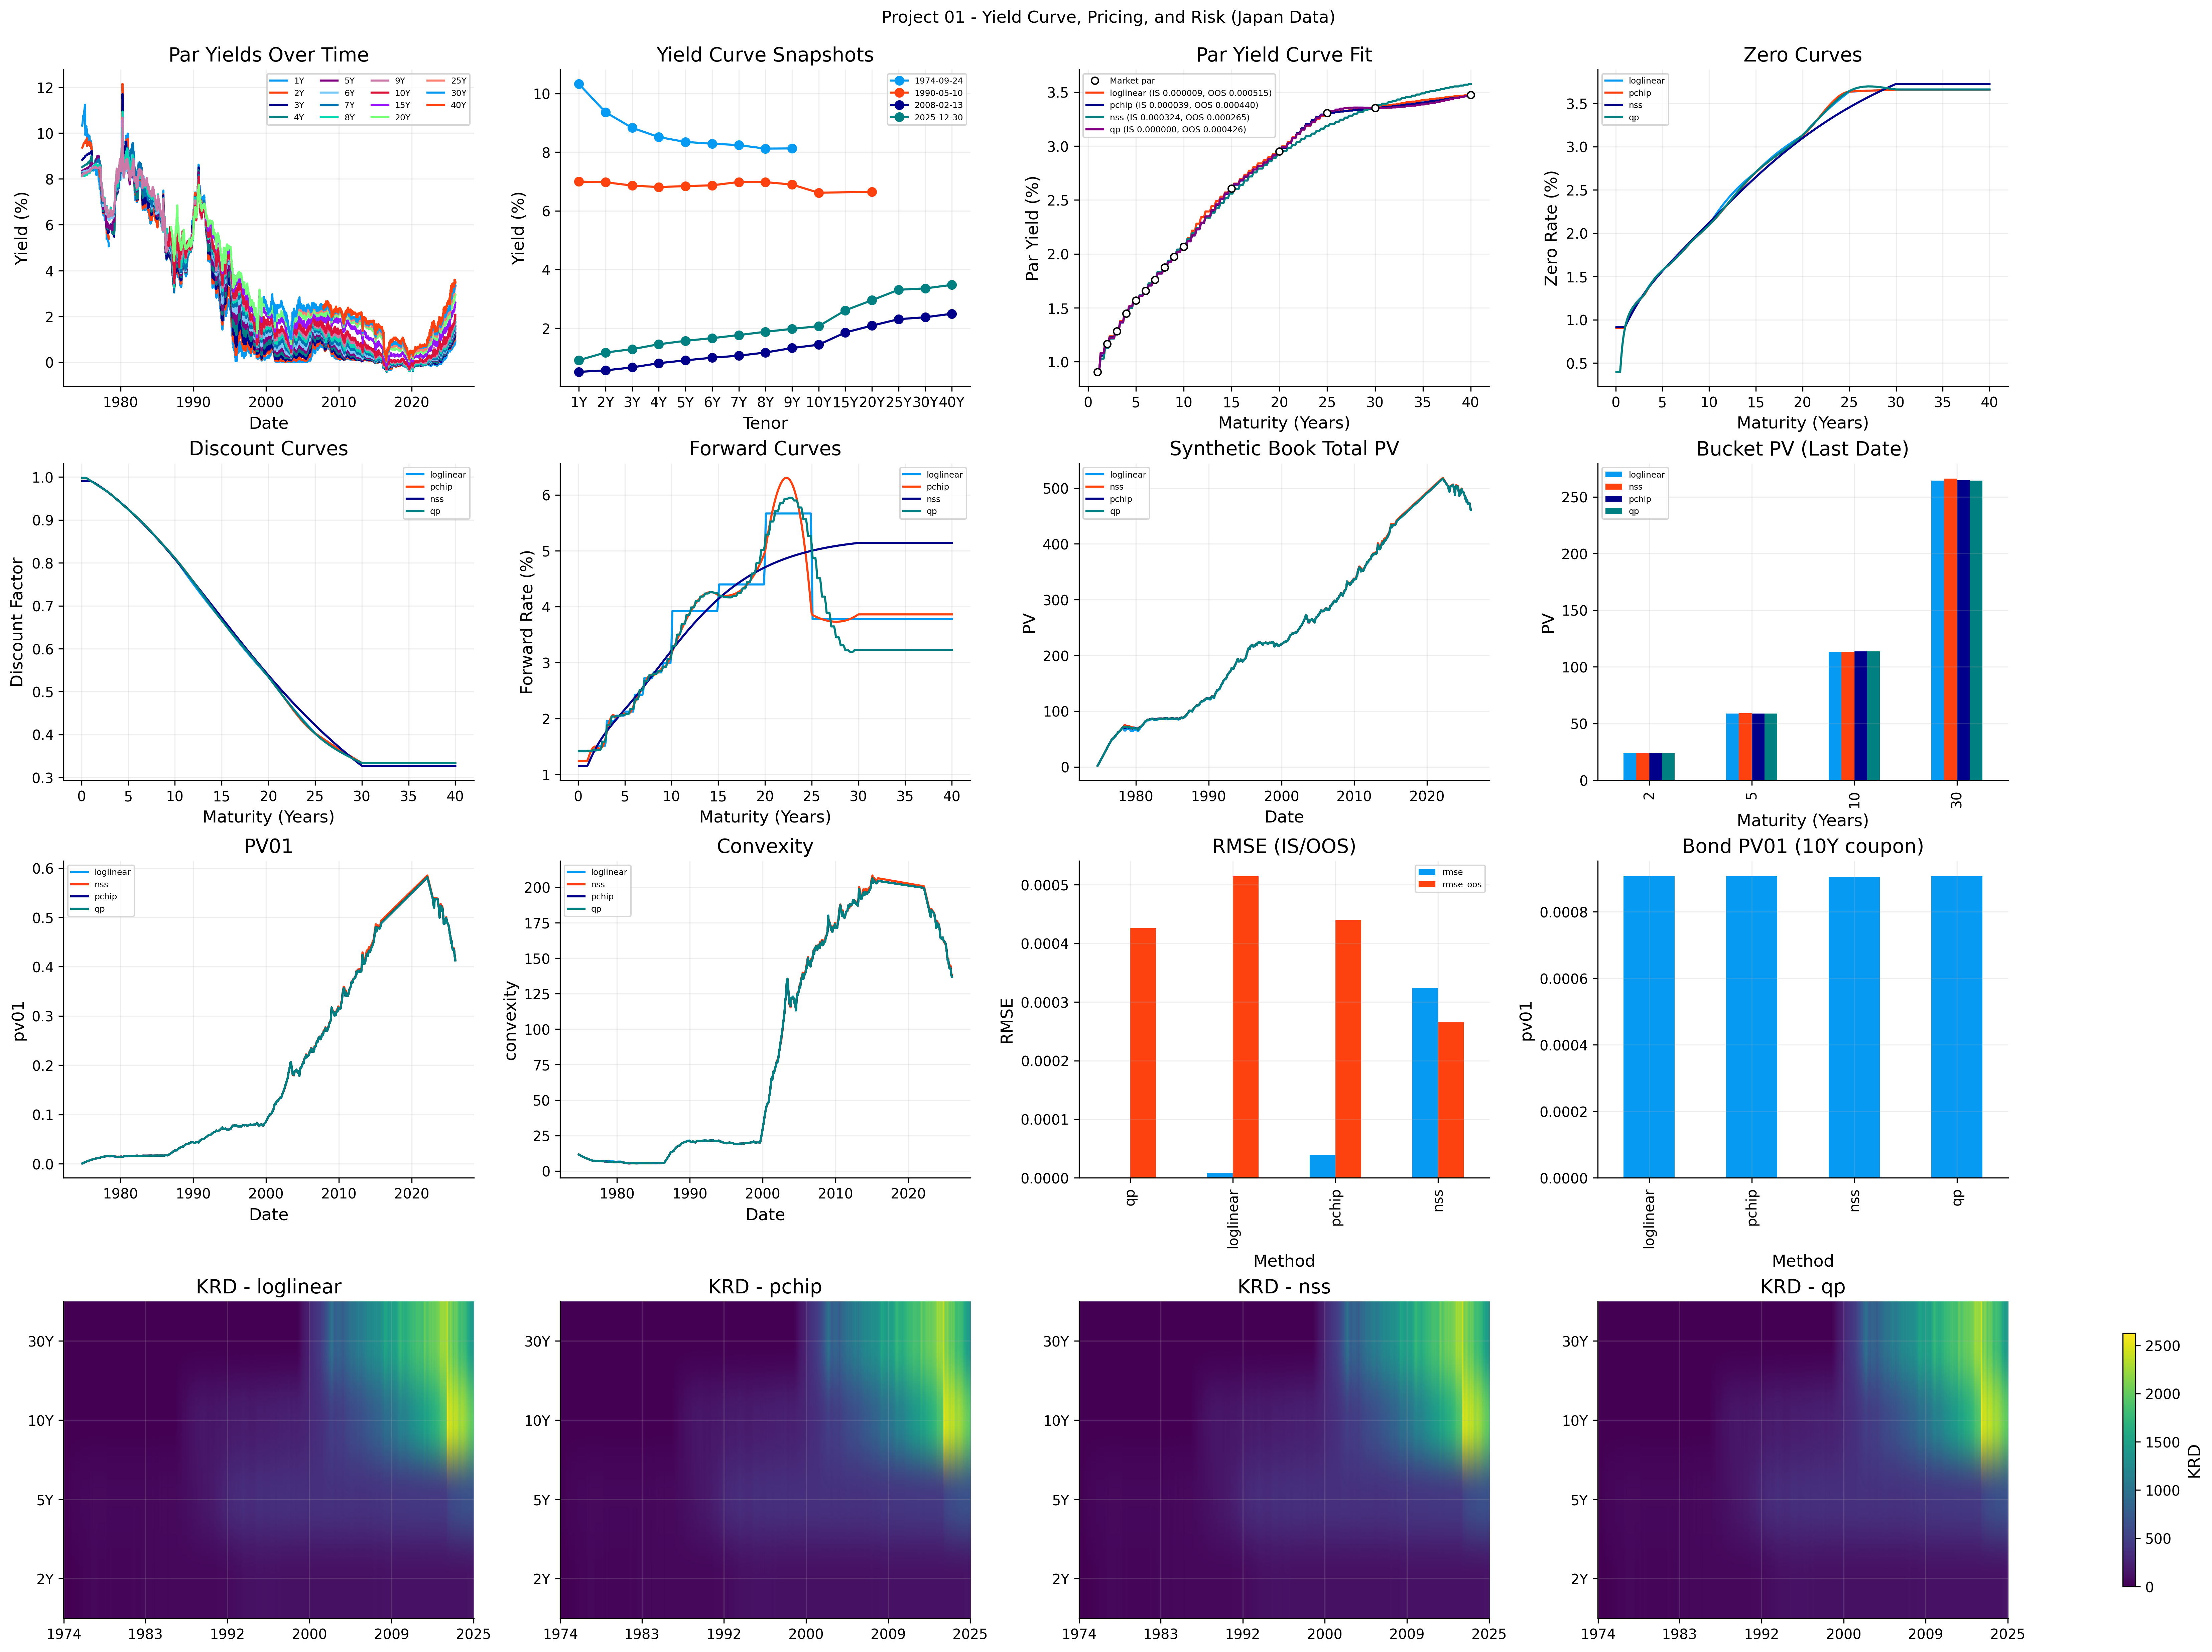

clean_price      pv01  convexity    krd_2Y    krd_5Y   krd_10Y  \
method                                                                      
loglinear     1.000000  0.000907  87.530846  0.098387  0.421344  8.514938   
pchip         1.000078  0.000907  87.524809  0.098400  0.421397  8.514987   
nss           0.997714  0.000905  87.497439  0.098420  0.421132  8.491704   
qp            1.000000  0.000907  87.522921  0.098397  0.421366  8.514131   

           krd_30Y  
method              
loglinear      0.0  
pchip          0.0  
nss            0.0  
qp             0.0

rmse  rmse_oos  n_obs  n_obs_oos  n_dates  n_dates_oos  \
method                                                                      
qp         2.833055e-09  0.000426   1100        400      100          100   
loglinear  8.669301e-06  0.000515   1100        400      100          100   
pchip      3.874855e-05  0.000440   1100        400      100          100   
nss        3.241647e-04  0.000265   1100        400      100          100   

           n_failed  
method               
qp                0  
loglinear         0  
pchip             0  
nss               0

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from pathlib import Path
import warnings
import quantfinlab.fixed_income as fi
import quantfinlab.plots as pl


warnings.filterwarnings("ignore")
path = Path("../data/japan_yield_curve_all.csv")

first_line = Path(path).read_text(encoding="utf-8", errors="ignore").splitlines()[0].strip().lower()
if first_line.startswith("interest rate"):
    raw = pd.read_csv(path, skiprows=1, na_values=["-"], keep_default_na=True)
else:
    raw = pd.read_csv(path, na_values=["-"], keep_default_na=True)

raw = raw.rename(columns={c: str(c).strip() for c in raw.columns})

def normalize_tenor_name(c):
    s = str(c).strip().upper().replace(" ", "")
    s = s.replace("MONTHS", "M").replace("MONTH", "M").replace("MOS", "M").replace("MO", "M")
    s = s.replace("YEARS", "Y").replace("YEAR", "Y").replace("YRS", "Y").replace("YR", "Y")
    return s

lower_cols = [c.lower() for c in raw.columns]
date_col = raw.columns[lower_cols.index("date")] if "date" in lower_cols else raw.columns[0]
raw = raw.rename(columns={date_col: "date"})
raw["date"] = pd.to_datetime(raw["date"], errors="coerce")
raw = raw.dropna(subset=["date"]).sort_values("date").set_index("date")

raw = raw.rename(columns={c: normalize_tenor_name(c) for c in raw.columns})
tenor_cols = [c for c in raw.columns if re.fullmatch(r"\d+(M|Y)", str(c))]
tenor_cols = sorted(tenor_cols, key=fi.tenor_to_years)

par = raw[tenor_cols].apply(pd.to_numeric, errors="coerce").dropna(how="all").sort_index()
if np.nanmedian(par.to_numpy(dtype=float)) > 1.0: 
    par = par / 100.0


methods = ["loglinear", "pchip", "nss", "qp"]
holdouts = ["2Y", "7Y", "20Y", "30Y"]
keys = [2, 5, 10, 30]
freq = 2
short_end = "continuous"
asof = fi.resolve_asof(par.index)

pillars = fi.bootstrap_pillars(par.loc[asof], asof=asof, tenor_cols=tenor_cols, freq=freq, short_end=short_end)
curves = fi.fit_curves(pillars, methods=methods, freq=freq)

curve_t_max = max(30.0, float(pillars.T.max()))
plot_grid = np.linspace(max(1 / 12, float(pillars.T.min())), float(pillars.T.max()), 250)
par_fit_table = fi.par_curve_table(curves, grid=plot_grid, freq=freq)
zero_table = fi.zero_curve_table(curves, t_min=1 / 12, t_max=curve_t_max, points=400)
df_table = fi.discount_curve_table(curves, t_min=1 / 12, t_max=curve_t_max, points=400)
fwd_table = fi.forward_curve_table(curves, t_min=1 / 12, t_max=curve_t_max, points=400)

rmse = fi.rmse_backtest(par.tail(100), methods=methods, holdouts=holdouts, freq=freq, short_end=short_end,
    tenor_cols=tenor_cols)

rmse_sorted = fi.sort_rmse_table(rmse, methods=methods)


month_end = par.resample("ME").last().dropna(how="all")
book = fi.synthetic_issuance_book(month_end, maturities=keys, freq=freq)

curves_for_dates = fi.curves_by_valuation_date(month_end.index, par, methods=methods, freq=freq,
    short_end=short_end, tenor_cols=tenor_cols)

pv_total, pv_buckets = fi.book_pv_timeseries(book, curves_for_dates)
risk_df = fi.book_parallel_risk_timeseries(book, curves_for_dates, bump_bp=1.0)
krd_df = fi.book_krd_timeseries(book, curves_for_dates, keys=keys, bump_bp=1.0)
metrics = fi.make_book_metrics(pv_total, pv_buckets, risk_df)


bond, used_tenor = fi.bond_from_par_curve_row(par.loc[asof], maturity_years=10, tenor_cols=tenor_cols, freq=freq)
bond_tbl = fi.bond_price_and_risk(bond,curves, bump_bp=1.0, key_tenors=keys).reindex(methods)

n = len(par.index)
sample_dates = [par.index[0], par.index[n // 3], par.index[(2 * n) // 3], par.index[-1]]


fig = plt.figure(figsize=(22, 16), constrained_layout=True)
gs = fig.add_gridspec(4, 4)

ax_all = fig.add_subplot(gs[0, 0])
pl.plot_par_yields_history(ax_all, par, title="Par Yields Over Time")

ax_snap = fig.add_subplot(gs[0, 1])
pl.plot_yield_curve_snapshots(ax_snap, par, tenor_cols=tenor_cols, sample_dates=sample_dates, title="Yield Curve Snapshots")

ax_par = fig.add_subplot(gs[0, 2])
pl.draw_market_par_points(ax_par, pillars.T, pillars.par)
rmse_label_map = {
    m: f"{m} (IS {rmse.loc[m, 'rmse']:.6f}, OOS {rmse.loc[m, 'rmse_oos']:.6f})" if m in rmse.index else m
    for m in methods
}
pl.draw_curve_lines(ax_par, par_fit_table, scale=100.0, label_map=rmse_label_map)
pl.style_axis(ax_par, title="Par Yield Curve Fit", xlabel="Maturity (Years)", ylabel="Par Yield (%)")

ax_zero = fig.add_subplot(gs[0, 3])
pl.plot_zero_curves(ax_zero, zero_table, title="Zero Curves")

ax_df = fig.add_subplot(gs[1, 0])
pl.plot_discount_curves(ax_df, df_table, title="Discount Curves")

ax_fwd = fig.add_subplot(gs[1, 1])
pl.plot_forward_curves(ax_fwd, fwd_table, title="Forward Curves")

ax_total = fig.add_subplot(gs[1, 2])
pl.plot_total_pv(ax_total, metrics.total_pv, title="Synthetic Book Total PV")

ax_bucket = fig.add_subplot(gs[1, 3])
pl.plot_bucket_pv(ax_bucket, metrics.bucket_pv, title="Bucket PV (Last Date)")

ax_pv01 = fig.add_subplot(gs[2, 0])
pl.plot_risk_metric(ax_pv01, metrics.risk, metric="pv01", title="PV01")

ax_conv = fig.add_subplot(gs[2, 1])
pl.plot_risk_metric(ax_conv, metrics.risk, metric="convexity", title="Convexity")

ax_rmse = fig.add_subplot(gs[2, 2])
pl.plot_rmse_bars(ax_rmse, rmse_sorted, title="RMSE (IS/OOS)")

ax_bond = fig.add_subplot(gs[2, 3])
pl.plot_bond_metric_bar(ax_bond, bond_tbl, metric="pv01", title=f"Bond PV01 ({used_tenor} coupon)")

krd_axes = [fig.add_subplot(gs[3, i]) for i in range(4)]
ims = []
for ax, method in zip(krd_axes, methods, strict=False):
    im = pl.plot_krd_heatmap(ax, krd_df, method=method, keys=keys, title=f"KRD - {method}")
    if im is not None:
        ims.append(im)
if ims:
    fig.colorbar(ims[0], ax=krd_axes, shrink=0.8, location="right", label="KRD")

fig.suptitle("Project 01 - Yield Curve, Pricing, and Risk (Japan Data)", y=1.02)
plt.show()

display(bond_tbl)
display(rmse_sorted)

